# Nea. ancestry trajectories under different demographic models

This is a simple analysis of the effect of demography ($N_e$ in particular) after the out of Africa bottleneck on the efficacy of selection against weakly deleterious mutations introgressed from Neanderthals.

Neanderthal ancestry in the population is measured on 10,000 exonic sites and 40,000 non-exonic sites carrying fixed neutral Nea. markers. The positions of these sites were subsampled from the coordinates of sites from the archaic admixture array. Deleterious mutations are accumulating in exonic regions only.

I considered three demographic models:

* classic Gravel et al. demographic model
* model of a constant $N_e = 10000$
* model of an initial linear growth until $N_e = 10000$ followed by a period exponential growth

In [612]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(lazyeval))
suppressPackageStartupMessages(library(reshape2))
library(stringr)

In [613]:
real_data_points <- function() {
    real_estimates <- read.table("../old_stuff/new_estimates.tsv", header=TRUE) %>%
    mutate(post_admixture=as.integer(post_admixture / 25))

    geom_point(aes(post_admixture, nea), data=real_estimates, alpha=0.5)
}

real_lm <- function() {
    real_estimates <- read.table("../old_stuff/new_estimates.tsv", header=TRUE) %>%
    mutate(post_admixture=as.integer(post_admixture / 25))

    geom_smooth(method="lm", aes(post_admixture, nea), data=real_estimates, size=0.5, alpha=0.25, linetype=2, se=FALSE, color="black")
}

### Function definitions

In [614]:
##
## Create a data frame with Nea. trajectories from all replicates.
##
load_trajectories <- function(sim_dir, scenario, dominance, init_nea, sites_subset) {
    if (!sites_subset %in% c("exonic", "nonexonic"))
        stop("Illegal subset of sites specified (must be \"exonic\" or \"nonexonic\").")

    # compose the pattern describing all input tables
    pattern <- paste0(scenario,
                      "__h_", dominance,
                      "__init_nea_", init_nea,
                      "__rep_.*",
                      "__", sites_subset, "_sites.txt")

    # get paths of all input tables
    files <- list.files(sim_dir, pattern, full.names=TRUE)

    # load each table individually
    tables <- lapply(seq_along(files),
           function(i) {
                   read.table(files[i], header=TRUE) %>%
                       mutate(rep=i,
                              model=scenario,
                              sites=sites_subset,
                              h=dominance)
           })

    # merge all dataframes into one and return the result
    do.call(rbind, tables)
}


##
## Calculate and plot the trajectory of a given statistic of the Neanderthal
## ancestry in a population.
##
plot_statistic <- function(trajectories, statistic, log_scale=FALSE) {
    # calculate the mean of a given summary statistic over all replicates
    summarized <-
        group_by(trajectories, gen, sites, model, h) %>%
        summarize_(statistic=interp(~mean(var), var=as.name(statistic)))
    
    p <-
        ggplot(summarized, aes(gen, statistic)) +
            geom_line(aes(color=sites)) +
            facet_grid(h ~ model) +
            labs(
                #title=paste("average trajectories of the",
            #                 paste0(statistic),
            #                 "Neanderthal ancestry"# on the",
#                             ifelse(log_scale, "log time scale", "normal time scale")
            #                ),
                 y=paste(statistic, "Nea. ancestry"),
                 x="generations after admixture") +
            theme(legend.position="bottom",
                  text=element_text(size=15))
    
    if (log_scale) {
        p <- p + scale_x_log10()
    }
    
    p
}


##
## Plot individual trajectories of a given statistic for each simulation
## replicate separately.
##
plot_replicates <- function(trajectories, statistic, dominance, log_scale=FALSE) {
    p <- 
        filter(trajectories, h == dominance) %>%
        melt(id=c("gen", "rep", "model", "sites"), measure=c(statistic)) %>%
        ggplot(aes(gen, value)) +
            geom_line(aes(color=factor(rep))) +
            facet_grid(model ~ sites) +
            labs(title=paste(statistic,
                             "Nea. ancestry change on the",
                             ifelse(log_scale, "log time scale", "normal time scale")),
                 y=statistic,
                 x="generations")
    
    if (log_scale) {
        p <- p + scale_x_log10()
    }
    
    p
}

# Mean Nea. % over time - constant, linear and Gravel demographic models

In [615]:
sites <- c("exonic", "nonexonic")
models <- c("constant", "linear", "gravel")
dominance <- c("1.0", "0.9", "0.5", "0.1", "0.0")

In [544]:
traject_dir <- "../simulations/different_models"

In [545]:
trajectories <-
    expand.grid(dominance=dominance, model=models, site=sites) %>%
    apply(1, function(comb) {
        load_trajectories(traject_dir, comb["model"], comb["dominance"], init_nea="0.1", comb["site"])
    }) %>%
    bind_rows %>%
    as_tibble

### Trajectories for h = {0, 0.1, 0.5, 0.9, 1}

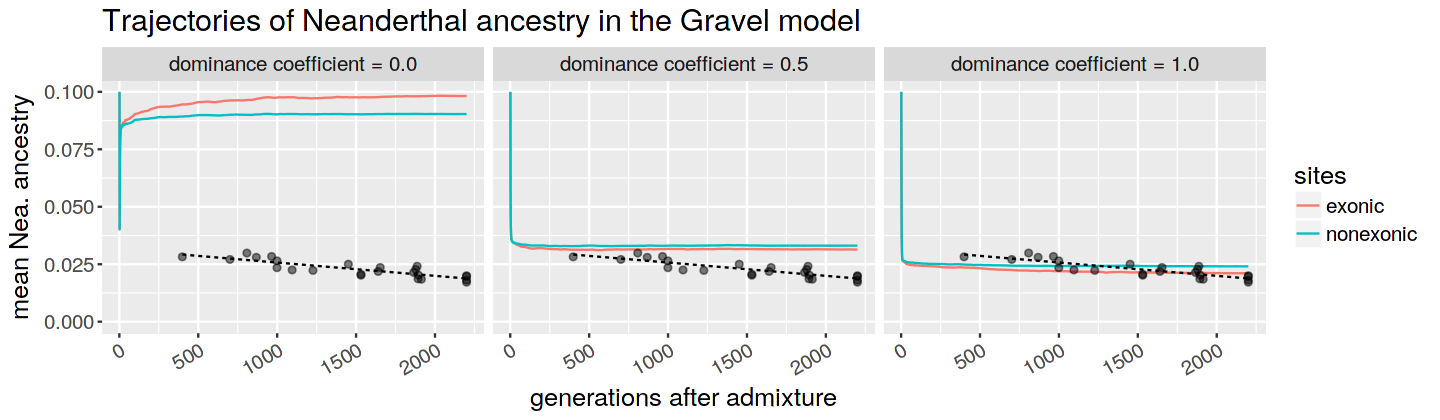

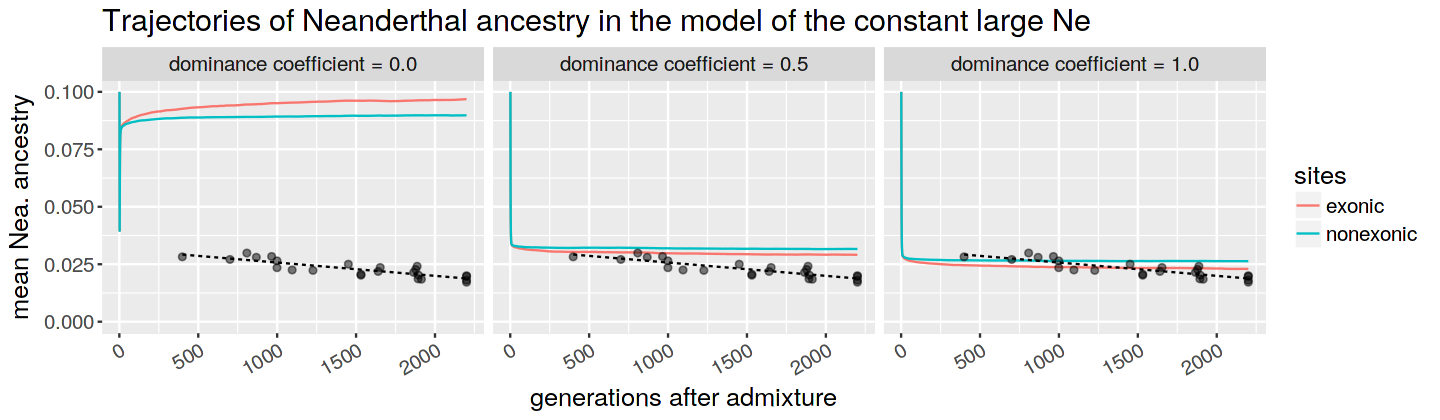

In [548]:
# SMBE
options(repr.plot.width=12, repr.plot.height=3.5)

filter(trajectories, model == "gravel", h != 0.1, h != 0.9) %>% 
mutate(h=paste0("dominance coefficient = ", h)) %>%
mutate(mean=ifelse(gen == 1, 0.1, mean)) %>% 
plot_statistic("mean") +
    ggtitle("Trajectories of Neanderthal ancestry in the Gravel model") +
    facet_grid(. ~ h) + ylim(0, 0.1) + real_data_points() + real_lm() +
    theme(axis.text.x = element_text(angle=30, hjust=1), legend.position="right")


filter(trajectories, model == "constant", h != 0.1, h != 0.9) %>% 
mutate(h=paste0("dominance coefficient = ", h)) %>%
mutate(mean=ifelse(gen == 1, 0.1, mean)) %>% 
plot_statistic("mean") +
    ggtitle("Trajectories of Neanderthal ancestry in the model of the constant large Ne") +
    facet_grid(. ~ h) + ylim(0, 0.1) + real_data_points() + real_lm() +
    theme(axis.text.x = element_text(angle=30, hjust=1), legend.position="right")

### Plot for the Fachbeirat presentation (mutations of h = 0.5)

Warning message:
“Removed 2 rows containing missing values (geom_path).”

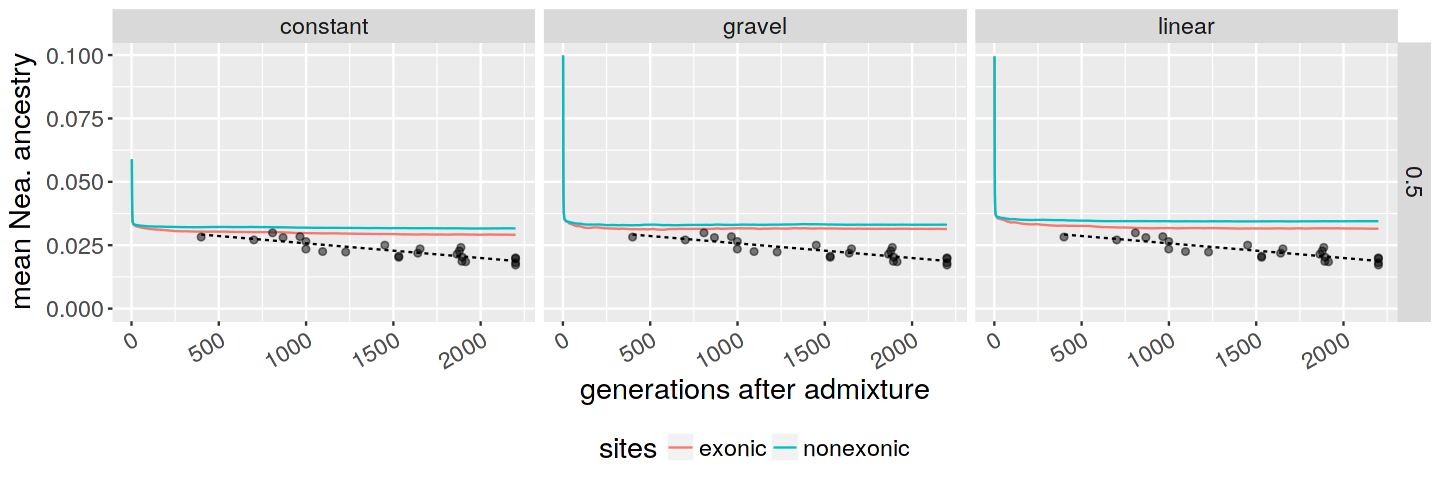

In [83]:
x <- read_tsv("../old_stuff/new_estimates.tsv") %>% mutate(post_admixture=as.integer(post_admixture / 25))

options(repr.plot.width=12, repr.plot.height=4.5)
filter(trajectories, h == "0.5") %>%
    plot_statistic("mean") +
    geom_point(aes(post_admixture, nea), data=x, alpha=0.5) +
    geom_smooth(method="lm", aes(post_admixture, nea), data=x, size=0.8, se=FALSE, color="black")

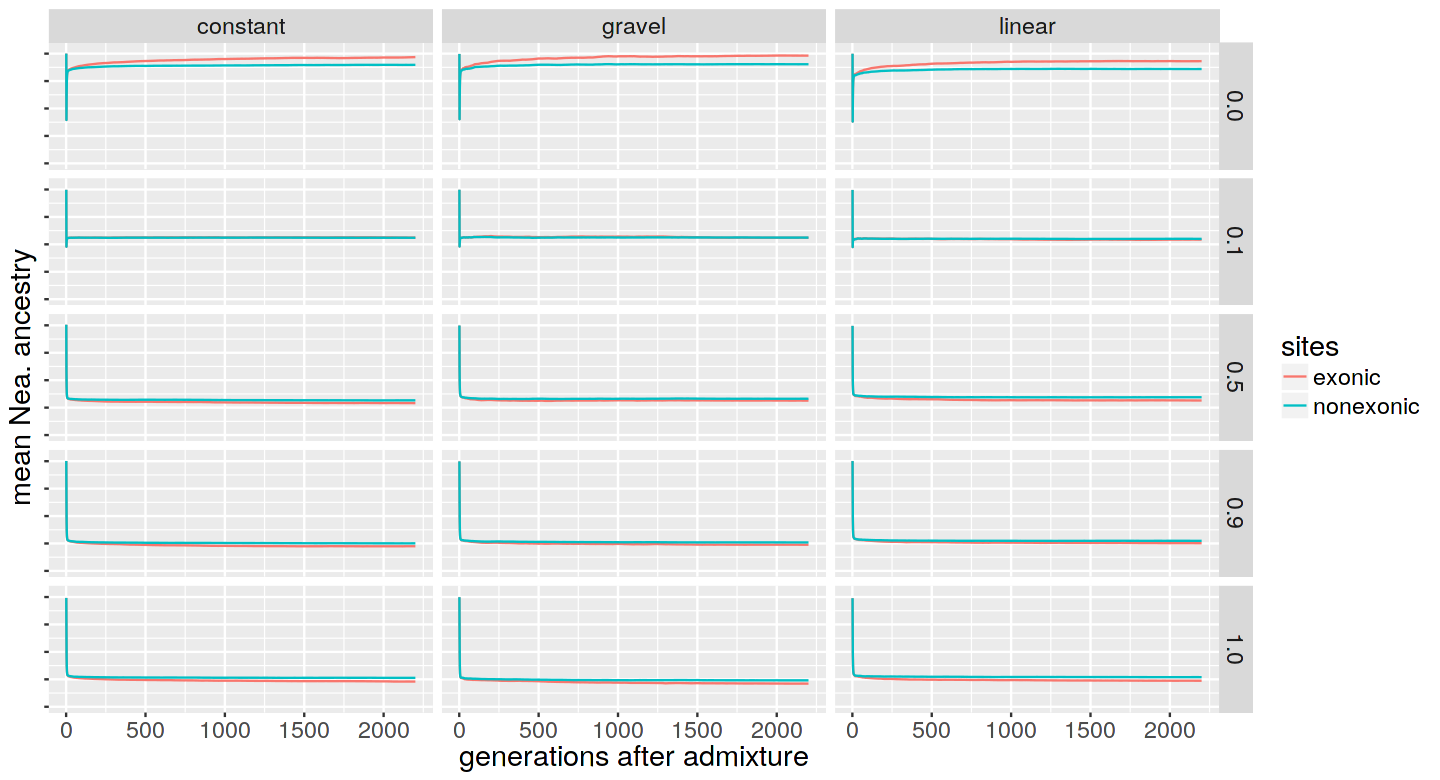

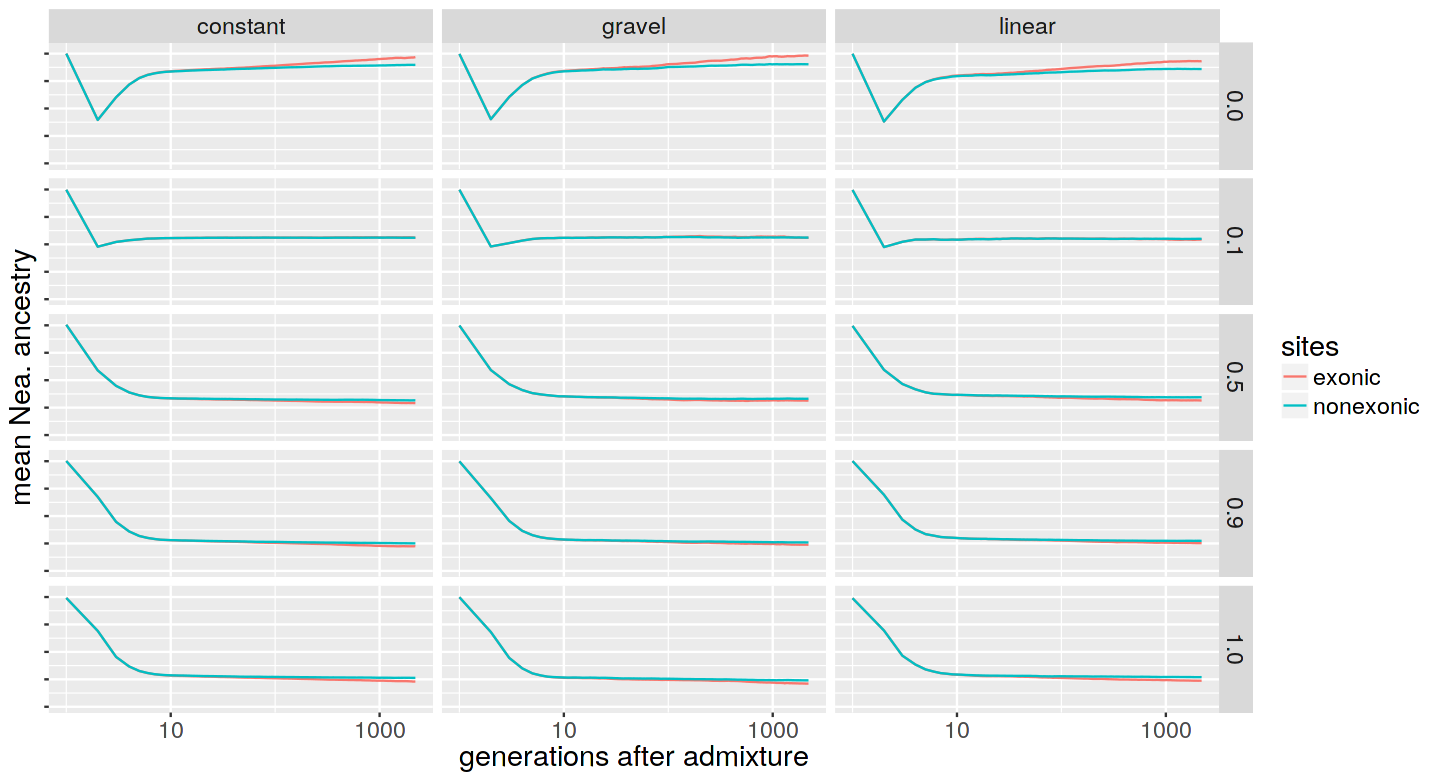

In [11]:
plot_statistic(trajectories, "mean") + theme(axis.text.y=element_blank(), legend.position="right")
plot_statistic(trajectories, "mean", log_scale=TRUE) + theme(axis.text.y=element_blank(), legend.position="right")

## Stdev. of the Nea. ancestry over time

Warning message:
"Removed 6 rows containing missing values (geom_path)."

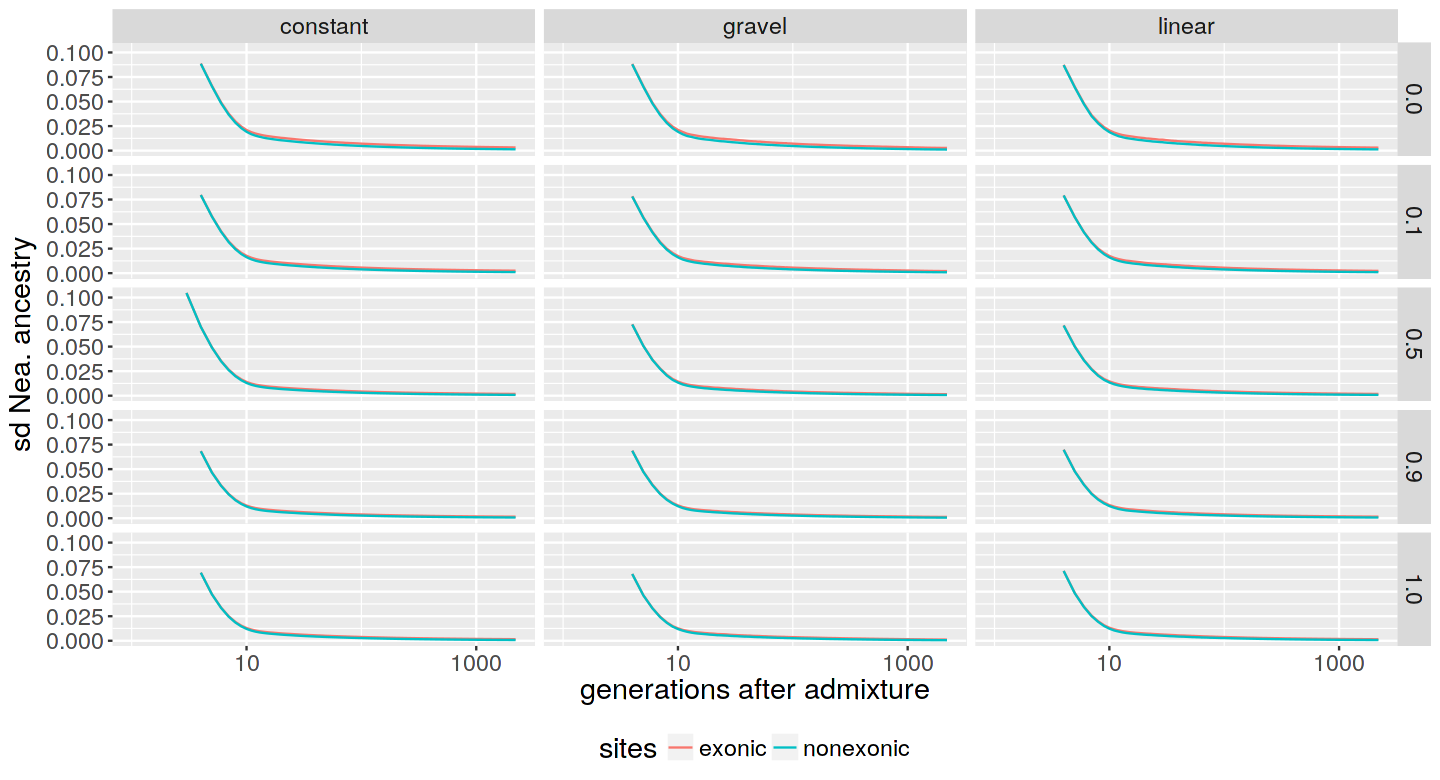

In [12]:
plot_statistic(trajectories, "sd", log_scale=TRUE)

### Nea. trajectories on neutral exonic/non-exonic sites for each individual replicate

The slope doesn't seem to be different between different demographic models. Therefore, selection efficacy is not particularly different under different $N_e$ of the population that received gene flow from Neanderthals.

What changes is the variance in the final level of Nea. ancestry in the population. This is highest under the Gravel model, which is not surprising, because this model predicts a _very_ long period of a _very_ narrow bottleneck (i.e. high drift for > 20 thousand years).

The variance between different replicates is caused by drift very early after the admixture pulse (recombination early after admixture has a higher chance of removing larger blocks of Nea. ancestry).

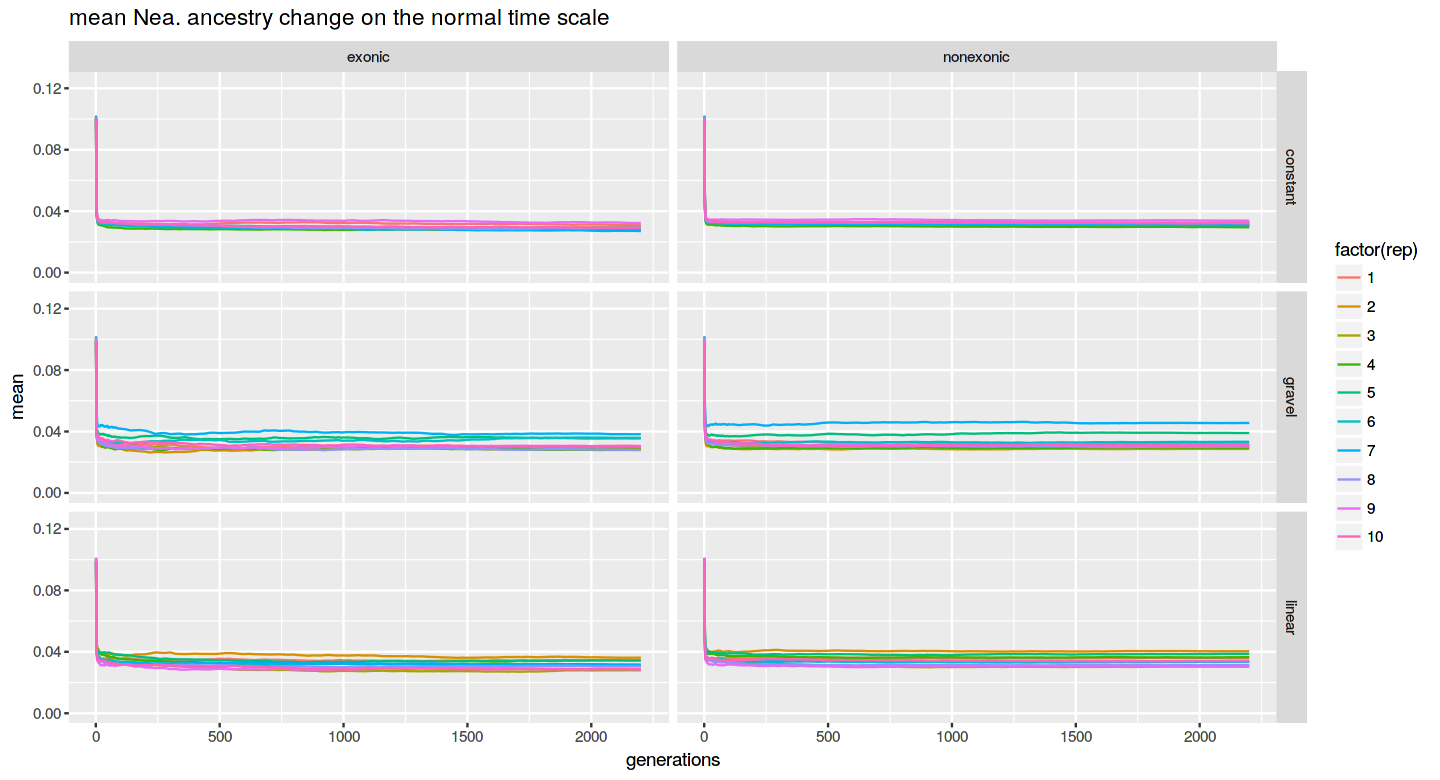

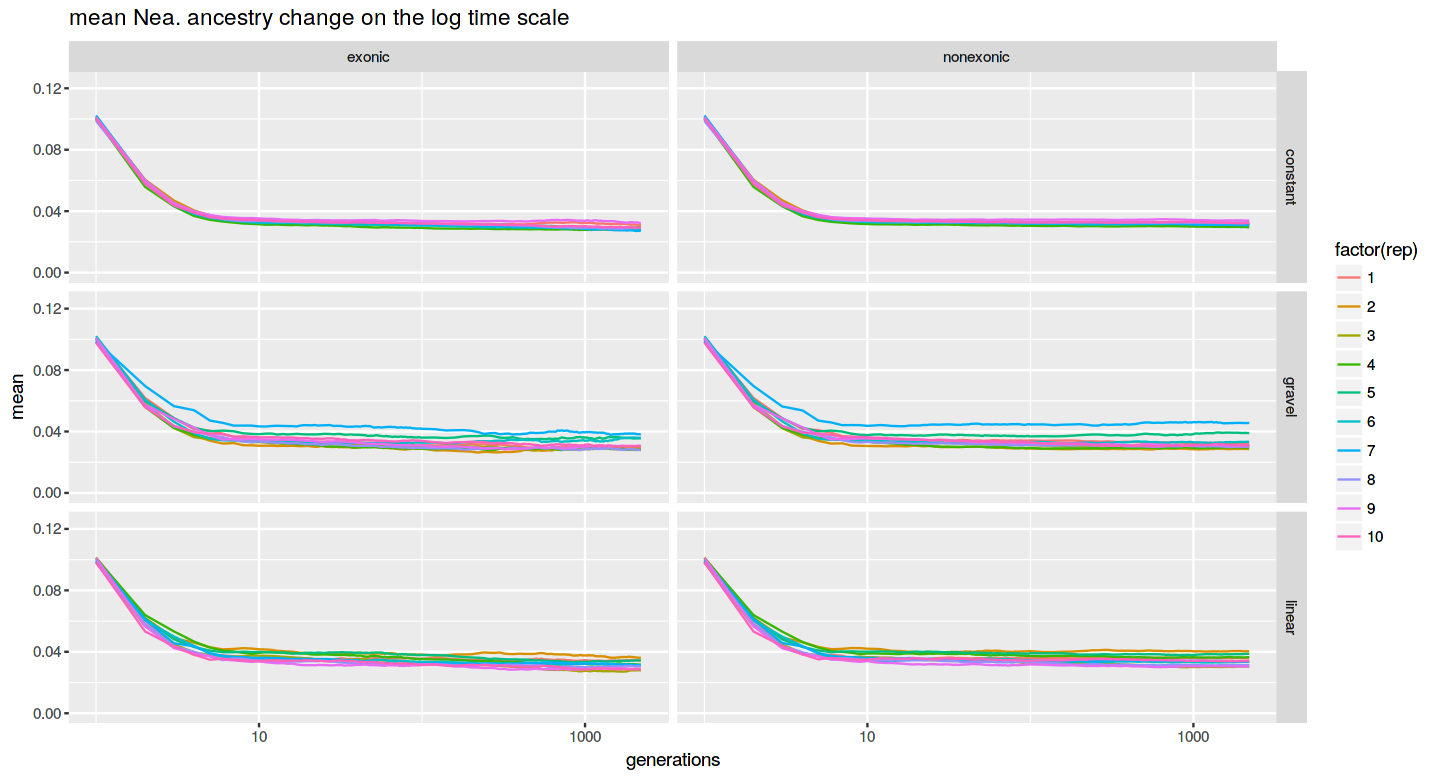

In [13]:
plot_replicates(trajectories, "mean", dominance="0.5")
plot_replicates(trajectories, "mean", dominance="0.5", log_scale=TRUE)

# Mean Nea. % over time - three different Neanderthal demographies

$N_e$ of AMH population after the split from the Neanderthals was constant ($N_e$ = 10000), remained constant even after Neanderthal admixture ($N_e$ = 10000).

**Notice the increasing variance in possible Nea% trajectories, with increasing $N_e$ of Neanderthals** -- more efficient selection in Neanderthals --> higher drift on introgressed alleles, because they are less deleterious.

**$N_e$ and the demographic history of the introgression strongly influences the initial dynamics**:

* hard to estimate the initial admixture rate
* Neanderthal $N_e$ affects only short-term dynamics, not the long-term dynamics - trajectories level off soon after the first ~20 generations

In [616]:
sites <- c("exonic", "nonexonic")
models <- c("Ne_100", "Ne_500", "Ne_1000", "Ne_10000")
dominance <- "0.5"

In [617]:
traject_dir <- "../simulations/nea_pop_sizes/"

In [561]:
trajectories <-
    expand.grid(dominance=dominance, model=models, site=sites) %>%
    apply(1, function(comb) {
        load_trajectories(traject_dir, comb["model"], comb["dominance"], init_nea="0.1", comb["site"])
    }) %>%
    bind_rows %>%
    as_tibble %>%
    mutate(model=factor(model, levels=c("Ne_100", "Ne_500", "Ne_1000", "Ne_10000")))

In [618]:
pl <- function (trajectories, statistic, log_scale = FALSE) 
{
    summarized <- group_by(trajectories, gen, model) %>% 
        summarize_(statistic = interp(~mean(var), var = as.name(statistic)))
    p <- ggplot(summarized, aes(gen, statistic)) + geom_line(aes(color = model)) + 
        labs(y = paste(statistic, "Nea. ancestry"), 
        x = "generations after admixture")
    if (log_scale) {
        p <- p + scale_x_log10()
    }
    p
}

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Warning message:
“Removed 740 rows containing missing values (geom_path).”

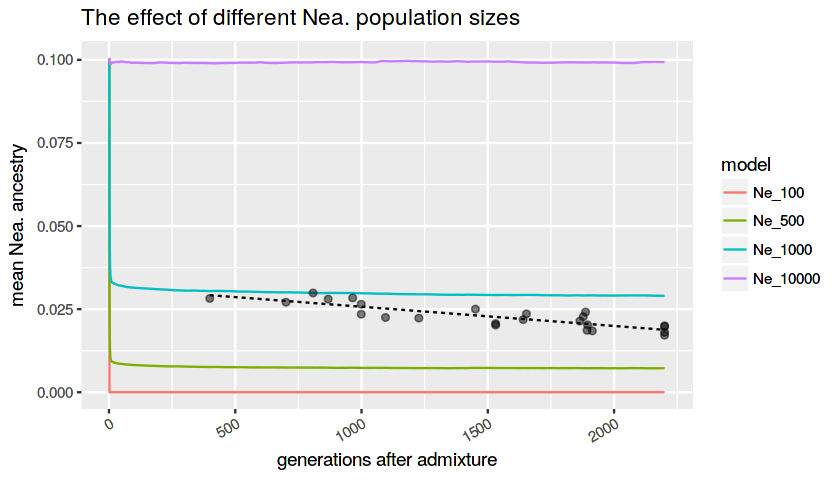

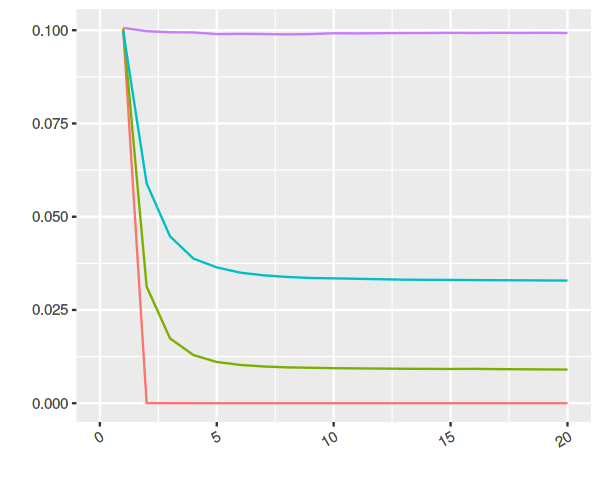

In [565]:
# SMBE
options(repr.plot.width=7, repr.plot.height=4)
pl(filter(trajectories, sites == "exonic"), "mean") +
    ggtitle("The effect of different Nea. population sizes") +
    theme(axis.text.x = element_text(angle=30, hjust=1)) + real_data_points() + real_lm()

options(repr.plot.width=5, repr.plot.height=4)
pl(trajectories, "mean", log_scale=TRUE) +
    theme(axis.text.x = element_text(angle=30, hjust=1), legend.position="none") + xlim(0, 20) +
    xlab("") + ylab("")

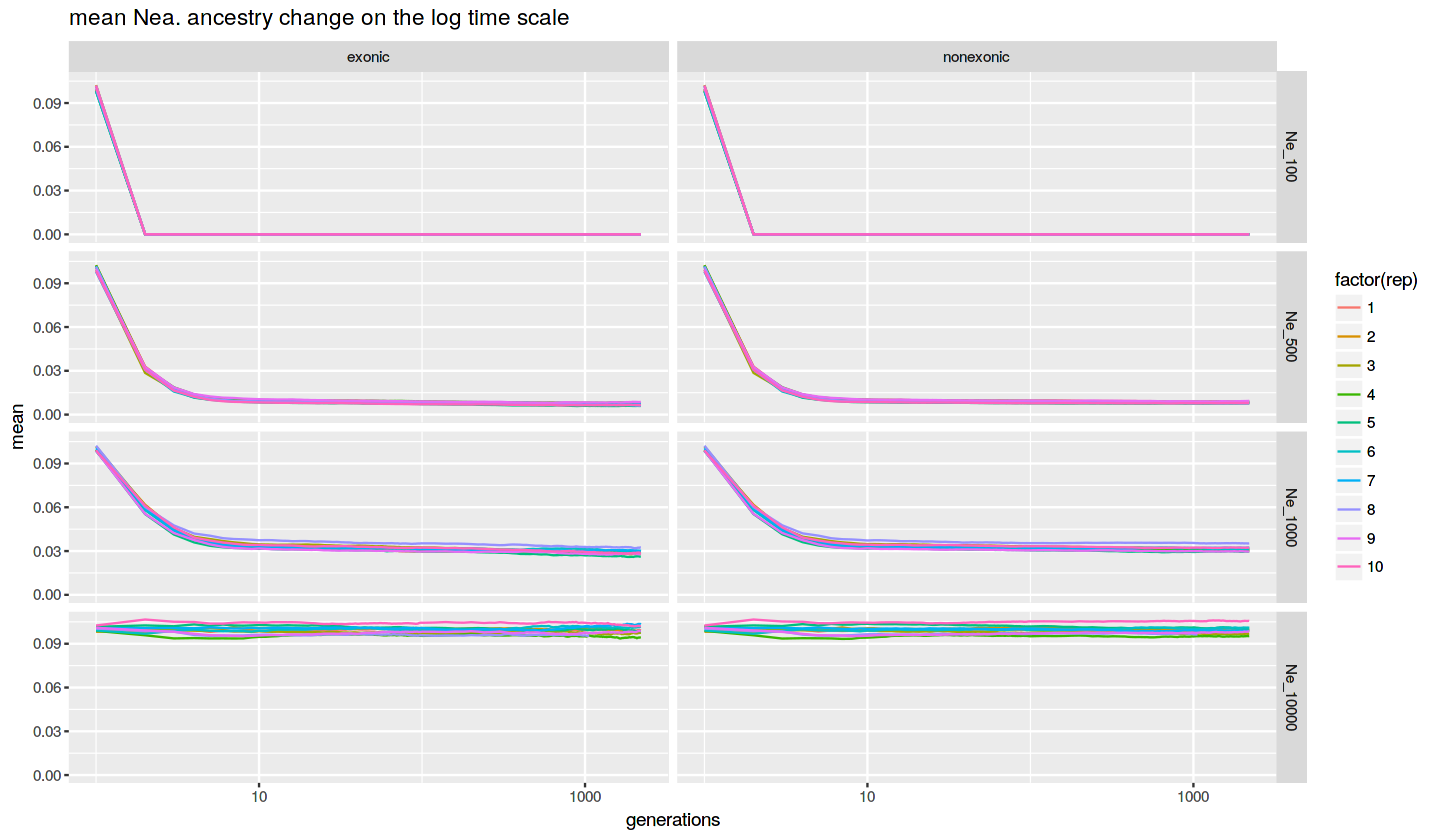

In [423]:
options(repr.plot.width=12, repr.plot.height=7)

plot_replicates(trajectories, "mean", dominance="0.5", log_scale=TRUE)

## Selection against fixed $s$ Nea. mutations (SMBE variant)

In [619]:
sites <- c("exonic", "nonexonic")
models <- c("unmodified", "fixed_s_4.7e-4")
dominance <- c("0.5")

In [620]:
traject_dir <- "../simulations/fixed_s"

In [627]:
trajectories <-
    expand.grid(dominance=dominance, model=models, site=sites) %>%
    apply(1, function(comb) {
        load_trajectories(traject_dir, comb["model"], comb["dominance"], init_nea="0.1", comb["site"])
    }) %>%
    bind_rows %>%
    as_tibble %>% mutate(model=ifelse(model == "fixed_s_4.7e-4", "fixed s = 4.7e-4", "unmodified s"),
                         model=factor(model, levels=c("unmodified s", "fixed s = 4.7e-4")))

In [628]:
options(repr.plot.width=12, repr.plot.height=4.5)

Warning message:
“Removed 1 rows containing missing values (geom_path).”

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Warning message:
“Removed 333 rows containing missing values (geom_path).”

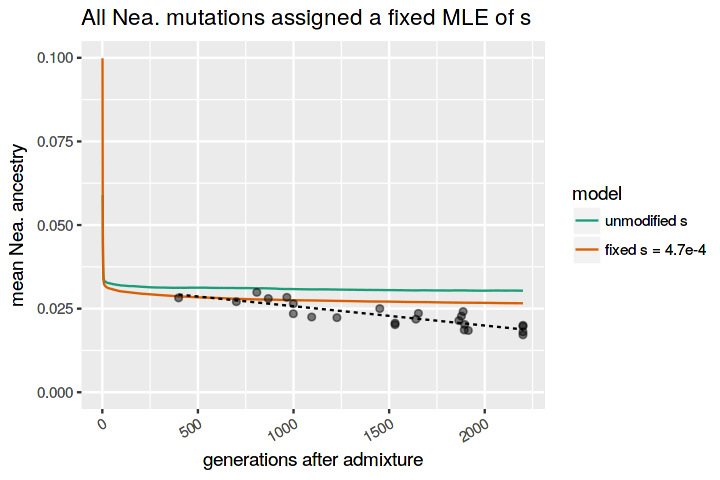

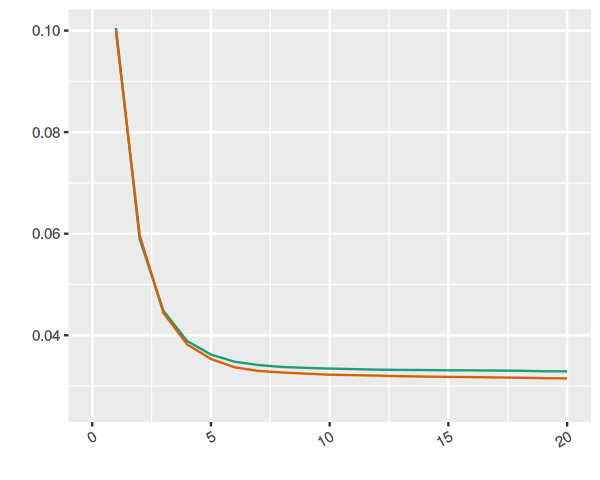

In [635]:
# SMBE
options(repr.plot.width=6, repr.plot.height=4)
pl(trajectories, "mean") +
    theme(axis.text.x = element_text(angle=30, hjust=1)) + real_data_points() + real_lm() + ylim(0, 0.1) +
    scale_color_brewer(palette="Dark2") +
    ggtitle("All Nea. mutations assigned a fixed MLE of s")

options(repr.plot.width=5, repr.plot.height=4)
pl(trajectories, "mean", log_scale=TRUE) +
    theme(axis.text.x = element_text(angle=30, hjust=1), legend.position="none") + xlim(0, 20) +
    xlab("") + ylab("") +
    scale_color_brewer(palette="Dark2")

## Bump-up $s$ after the introgression

In [572]:
sites <- c("exonic", "nonexonic")
models <- paste0("multiplier_", c("1.5", "2.5", "5.0", "10.0", "50.0", "unmodified"))
dominance <- "0.5"

In [573]:
traject_dir <- "../simulations/bump_up_dfe2/"

In [574]:
trajectories <-
    expand.grid(dominance=dominance, model=models, site=sites) %>%
    apply(1, function(comb) {
        load_trajectories(traject_dir, comb["model"], comb["dominance"], init_nea="0.1", comb["site"])
    }) %>%
    bind_rows %>%
    as_tibble %>%
    mutate(model=factor(
                                            ifelse(model == "multiplier_unmodified",
                                            "unmodified s",
                                            str_replace(model, "multiplier_", "s multiplied by ")),
                                            levels=c("unmodified s",
                                                     paste0("s multiplied by ", c("1.5", "2.5", "5.0", "10.0", "50.0")))))

Warning message:
“Removed 4 rows containing missing values (geom_path).”

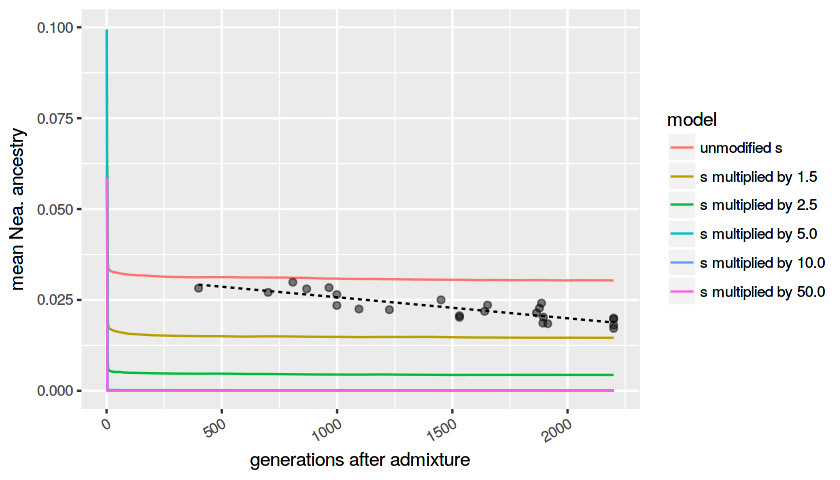

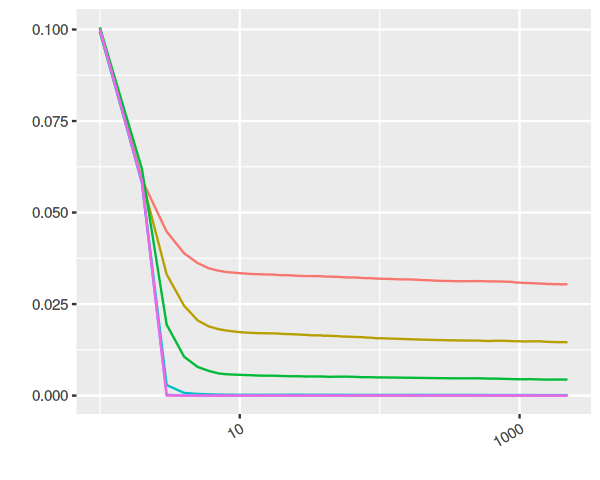

In [575]:
# SMBE
options(repr.plot.width=7, repr.plot.height=4)
pl(trajectories, "mean") +
    theme(axis.text.x = element_text(angle=30, hjust=1)) + real_data_points() + real_lm() + ylim(0, 0.1)

options(repr.plot.width=5, repr.plot.height=4)
pl(trajectories, "mean", log_scale=TRUE) +
    theme(axis.text.x = element_text(angle=30, hjust=1), legend.position="none") + 
    xlab("") + ylab("")

## Bump-up $s$ after the introgression

In [452]:
load_trajectories <- function(sim_dir, modifier, fraction, dominance, init_nea, sites_subset) {
    if (!sites_subset %in% c("exonic", "nonexonic"))
        stop("Illegal subset of sites specified (must be \"exonic\" or \"nonexonic\").")

    # compose the pattern describing all input tables
    pattern <- paste0(paste0("modify_by_", modifier, "__fraction_", fraction),
                      "__h_", dominance,
                      "__init_nea_", init_nea,
                      "__rep_.*",
                      "__", sites_subset, "_sites.txt")

    # get paths of all input tables
    files <- list.files(sim_dir, pattern, full.names=TRUE)

    # load each table individually
    tables <- lapply(seq_along(files),
           function(i) {
                   read.table(files[i], header=TRUE) %>%
                       mutate(rep=i,
                              modifier=modifier,
                              fraction=fraction,
                              sites=sites_subset,
                              h=dominance)
           })

    # merge all dataframes into one and return the result
    do.call(rbind, tables)
}

In [453]:
sites <- c("exonic", "nonexonic")
models <- c("constant", "linear", "gravel")
modifier <- c("1.5", "2.5", "5.0", "10.0", "50.0")
fraction <- c("1.0", "0.75", "0.5", "0.25", "0.1")
dominance <- "0.5"

In [454]:
traject_dir <- "../simulations/single_pulse_bump_up/"

In [455]:
trajectories <-
    expand.grid(dominance=dominance, modifier=modifier, fraction=fraction, site=sites) %>%
        bind_rows(data.frame(dominance=c("0.5", "0.5"),
                             modifier=rep("unmodified", 2),
                             fraction=rep("unmodified", 2),
                             site=c("exonic", "nonexonic"))) %>%
    apply(1, function(comb) {
        load_trajectories(traject_dir, comb["modifier"], comb["fraction"],
                          comb["dominance"], init_nea="0.1", comb["site"])
    }) %>%
    bind_rows %>%
    as_tibble

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

In [456]:
pl <- function (trajectories, statistic, log_scale = FALSE) 
{
    summarized <- group_by(trajectories, gen, sites, modifier, fraction, h) %>% 
        summarize_(statistic = interp(~mean(var), var = as.name(statistic))) %>%
        filter(gen <= 500)
    p <- ggplot(summarized, aes(gen, statistic)) + geom_line(aes(color=modifier, group=modifier)) + 
        facet_grid(fraction ~ sites) + labs(y = paste(statistic, "Nea. ancestry"), 
        x = "generations after admixture") + theme(legend.position = "right", 
        text = element_text(size = 17))
    if (log_scale) {
        p <- p + scale_x_log10()
    }
    p
}

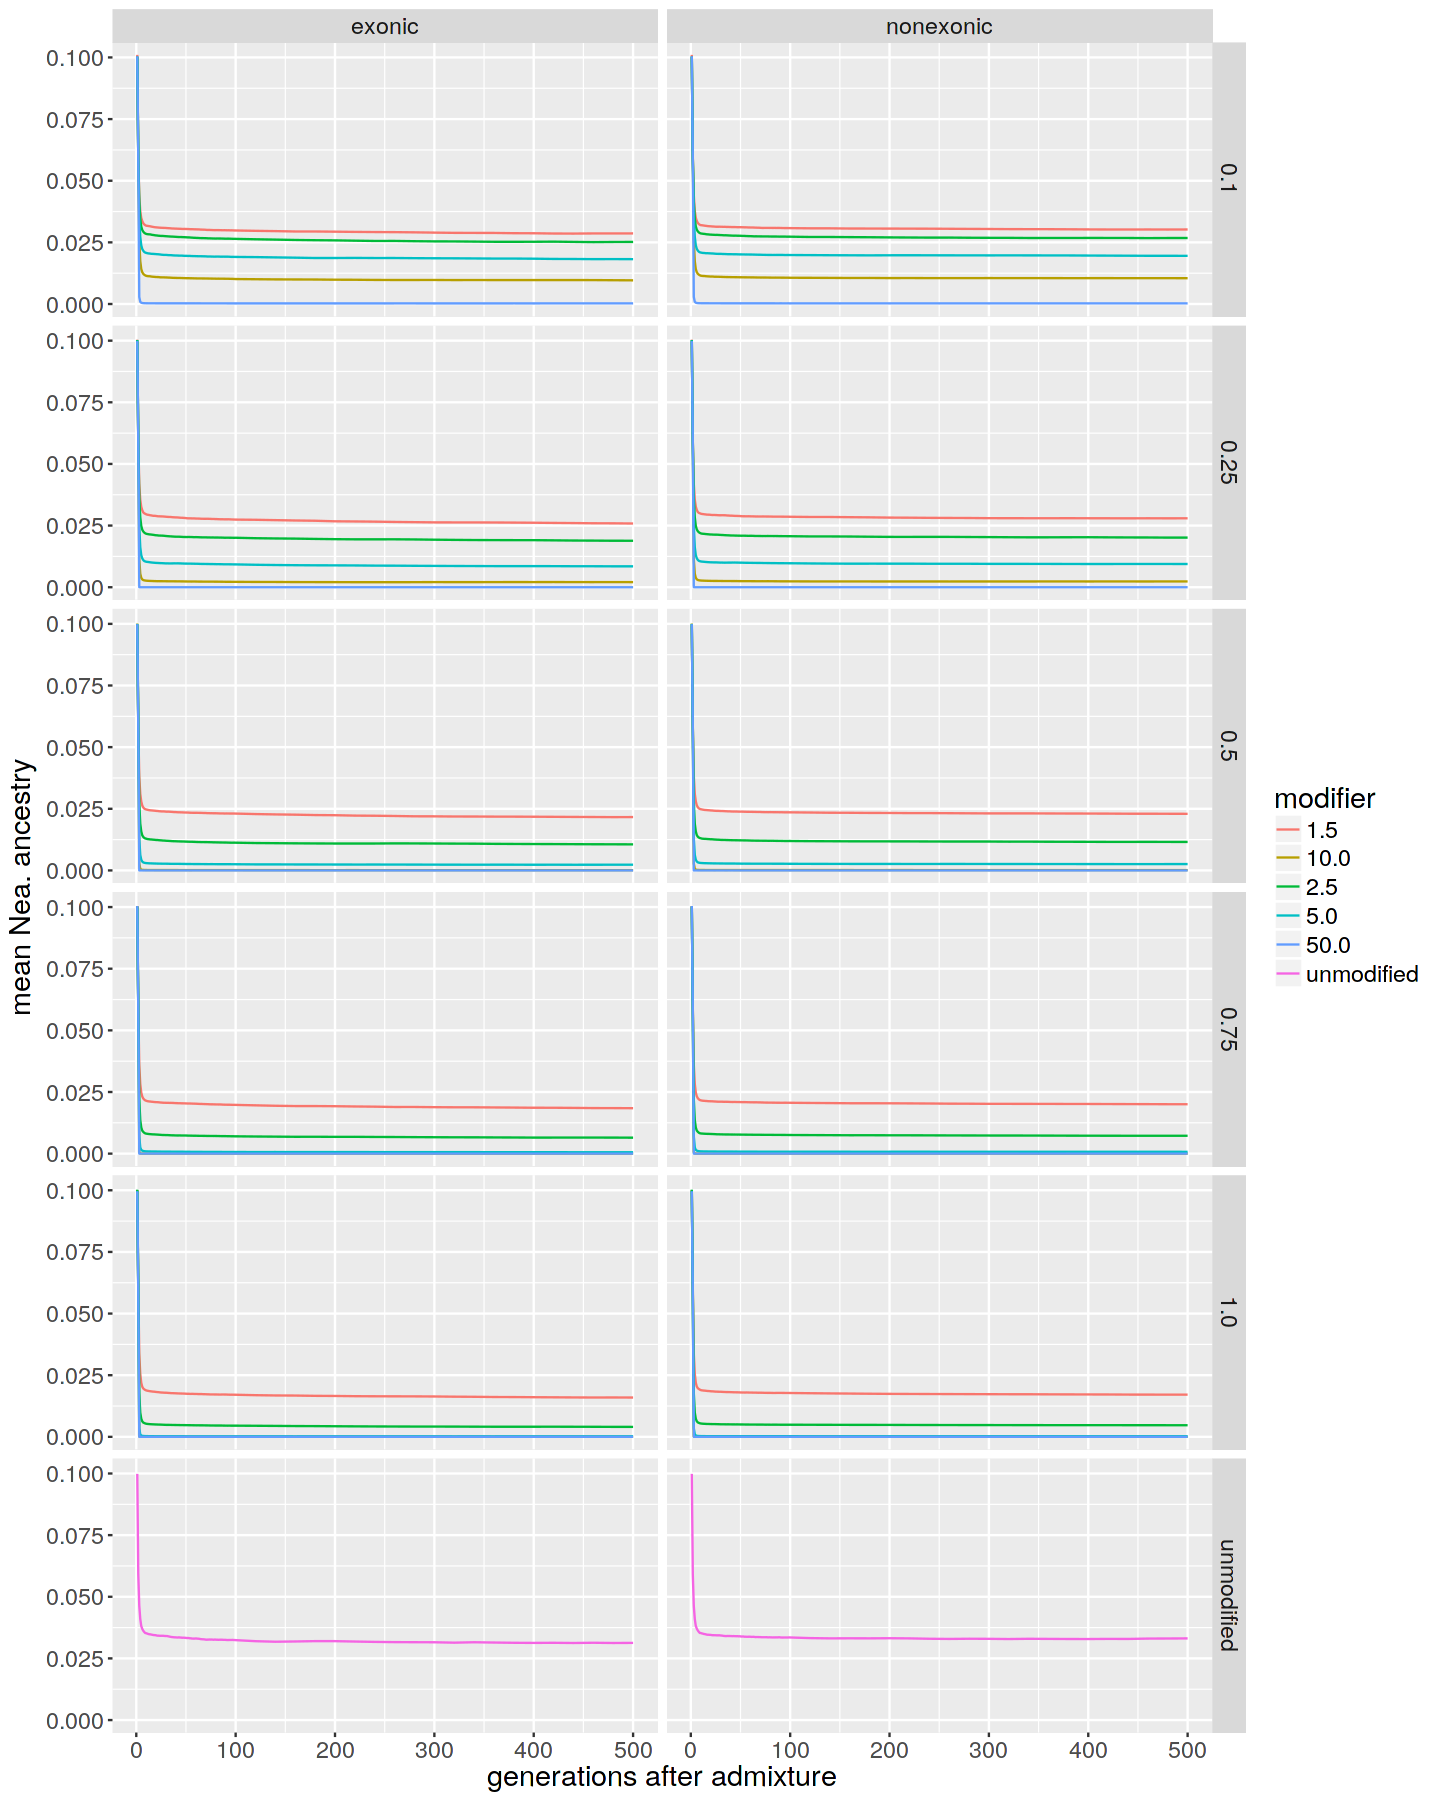

In [457]:
options(repr.plot.width=12, repr.plot.height=15)

pl(trajectories, "mean")

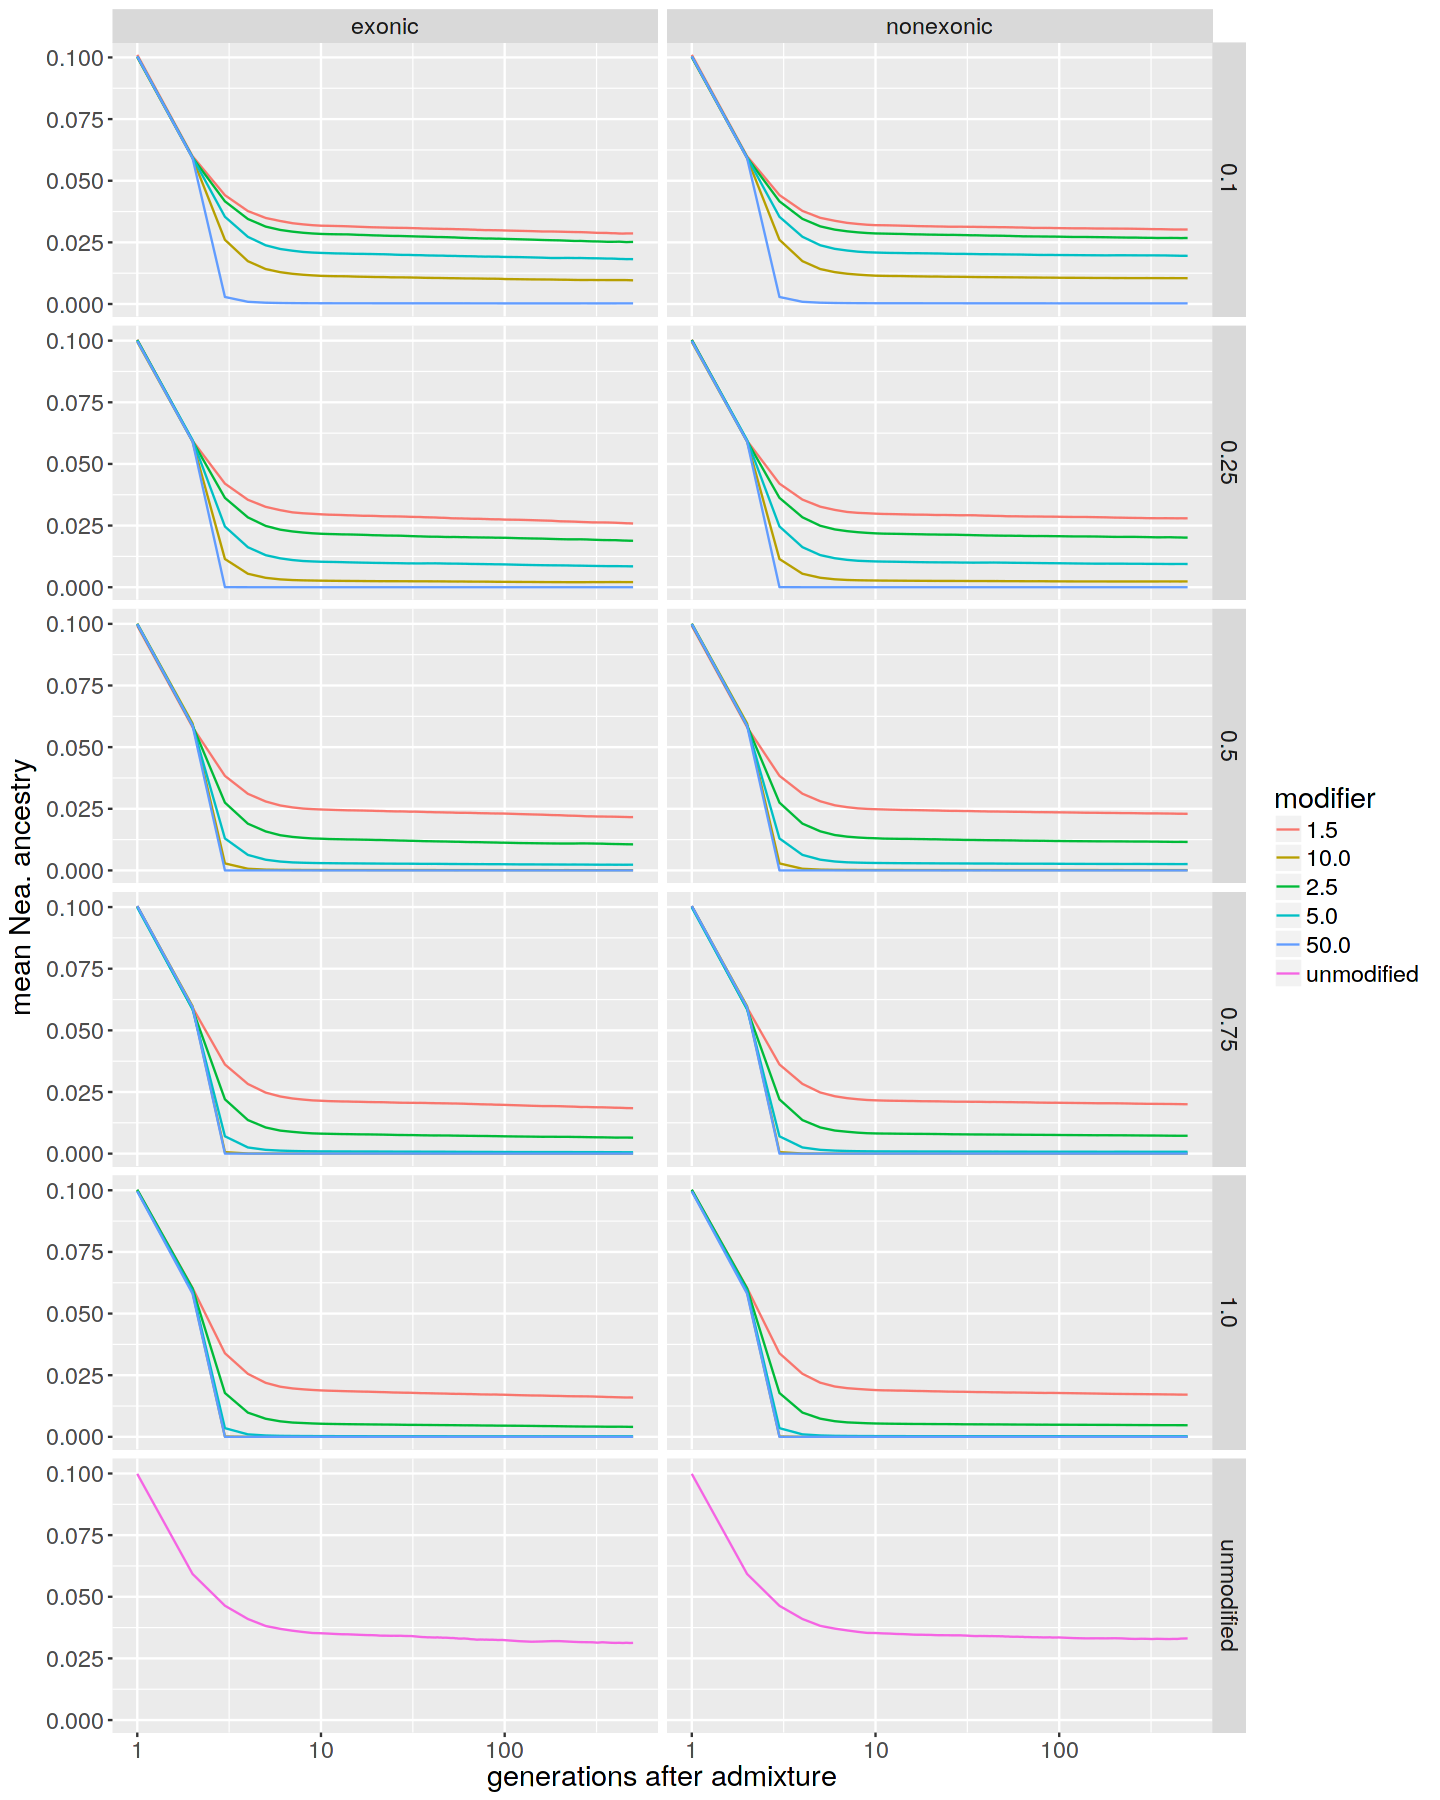

In [458]:
options(repr.plot.width=12, repr.plot.height=15)

pl(trajectories, "mean", log_scale=TRUE)

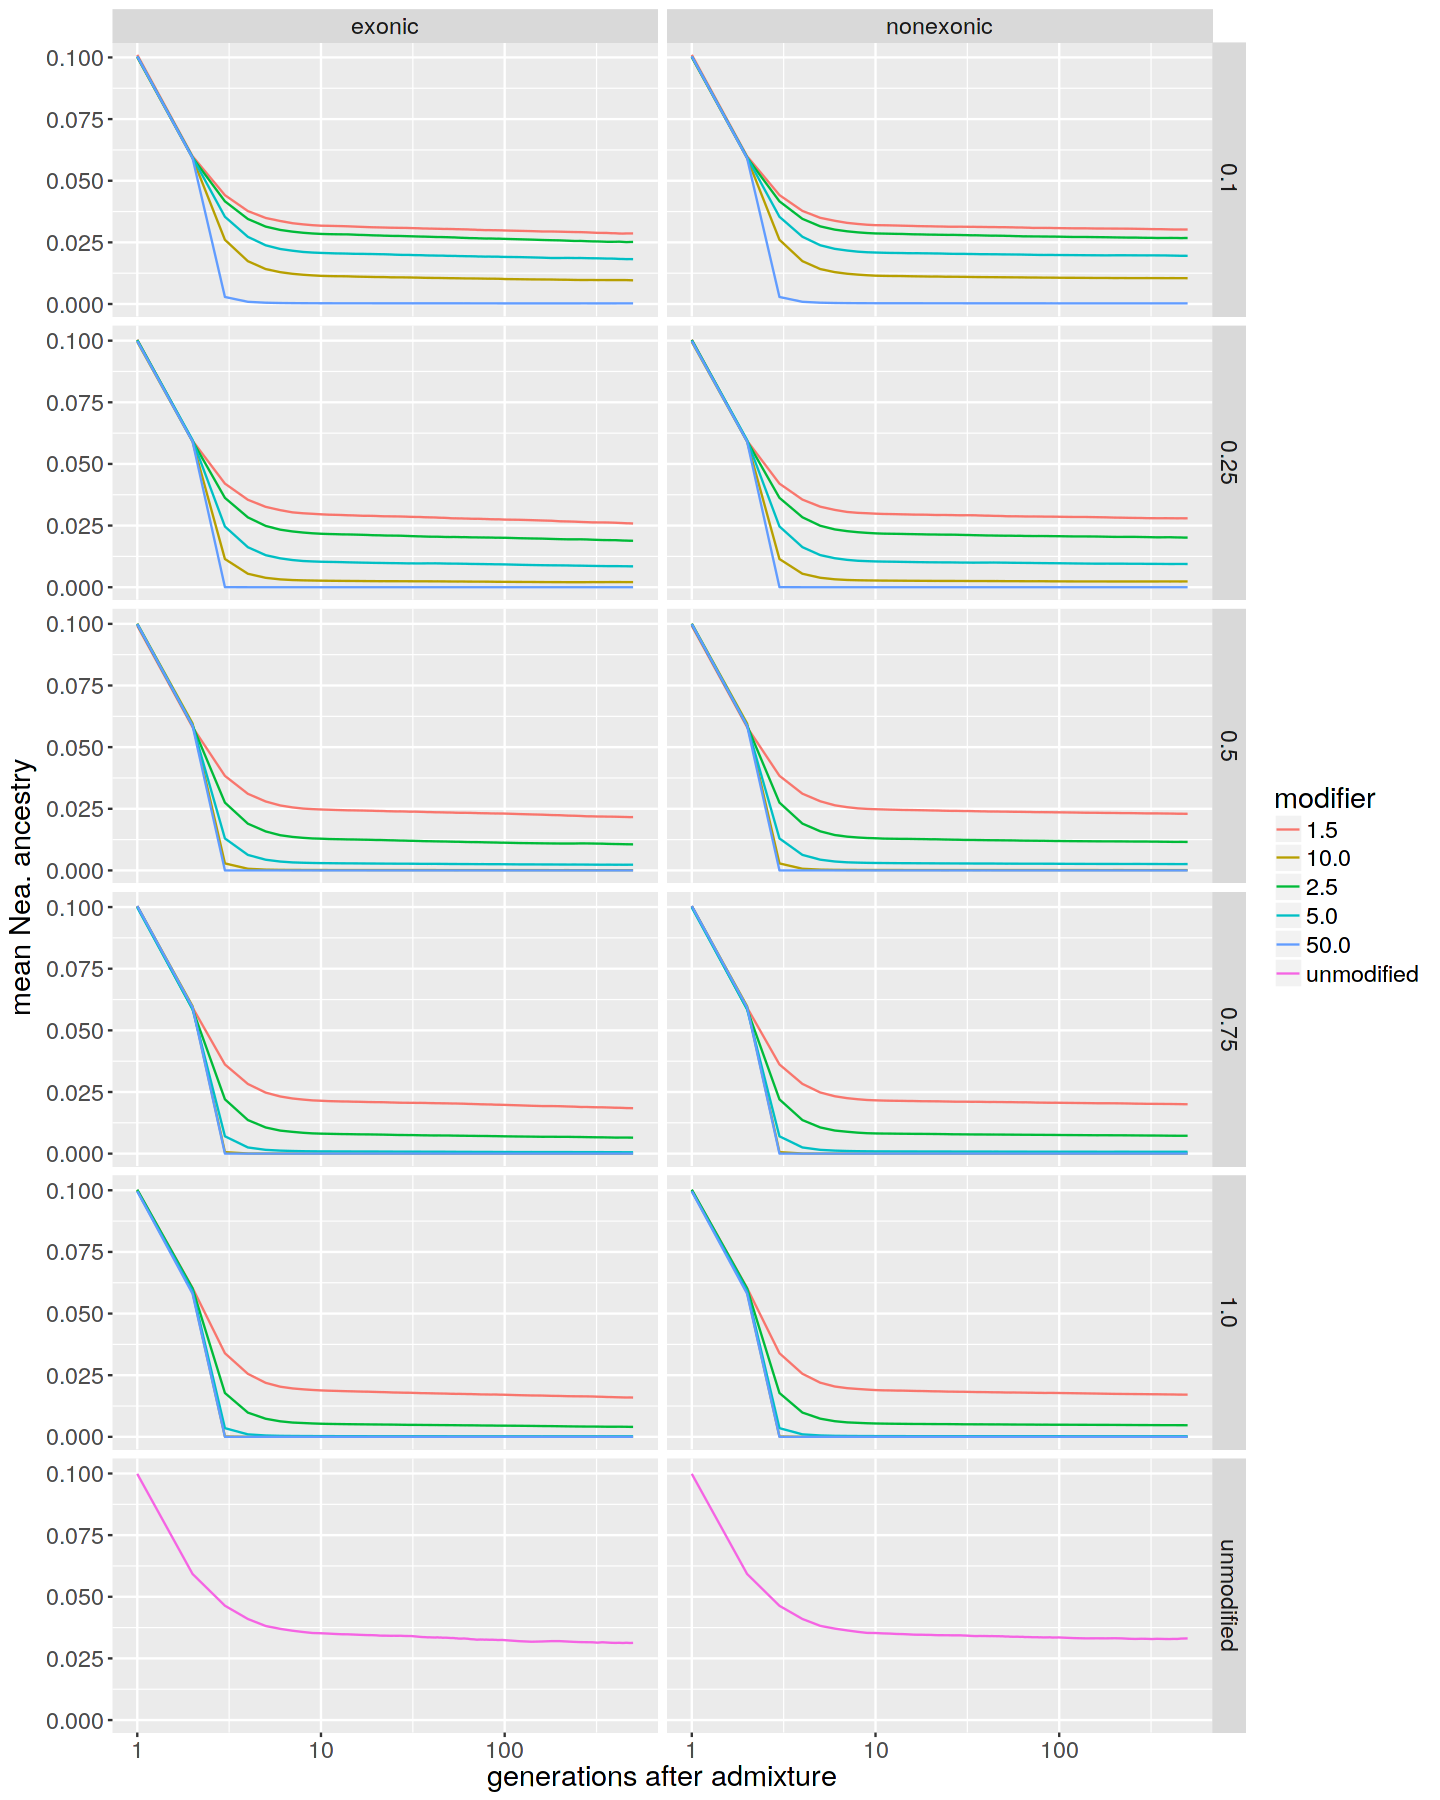

In [173]:
options(repr.plot.width=12, repr.plot.height=15)

pl(trajectories, "mean", log_scale=TRUE)

# Different time gaps between ooA migration and introgression

In [35]:
sites <- c("exonic", "nonexonic")
models <- c("ooa_55000", "ooa_80000", "ooa_100000")
dominance <- c("0.5", "0.1", "0.0")

In [36]:
traject_dir <- "../simulations/earlier_ooa/"

In [37]:
trajectories <-
    expand.grid(dominance=dominance, model=models, site=sites) %>%
    apply(1, function(comb) {
        load_trajectories(traject_dir, comb["model"], comb["dominance"], init_nea="0.1", comb["site"])
    }) %>%
    bind_rows %>%
    as_tibble %>%
    mutate(model=factor(model, levels=c("ooa_55000", "ooa_80000", "ooa_100000")))

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


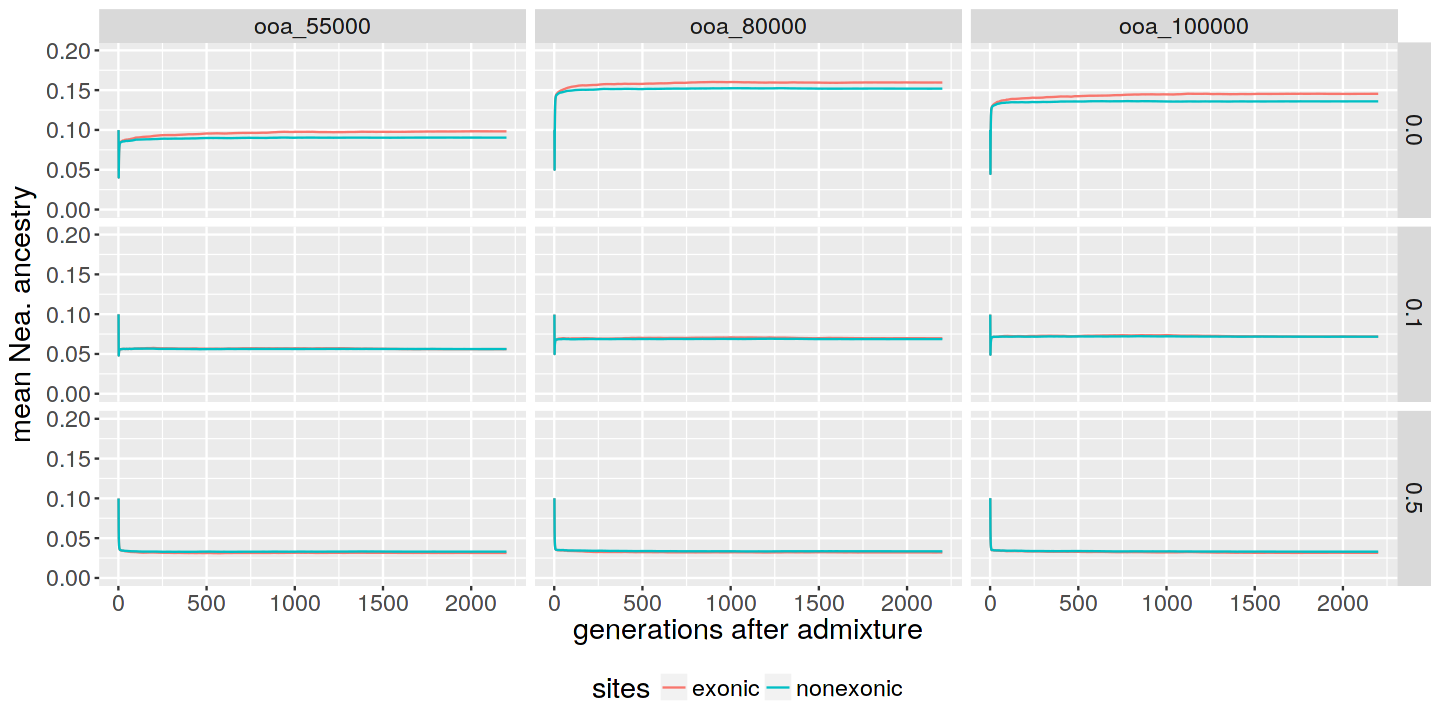

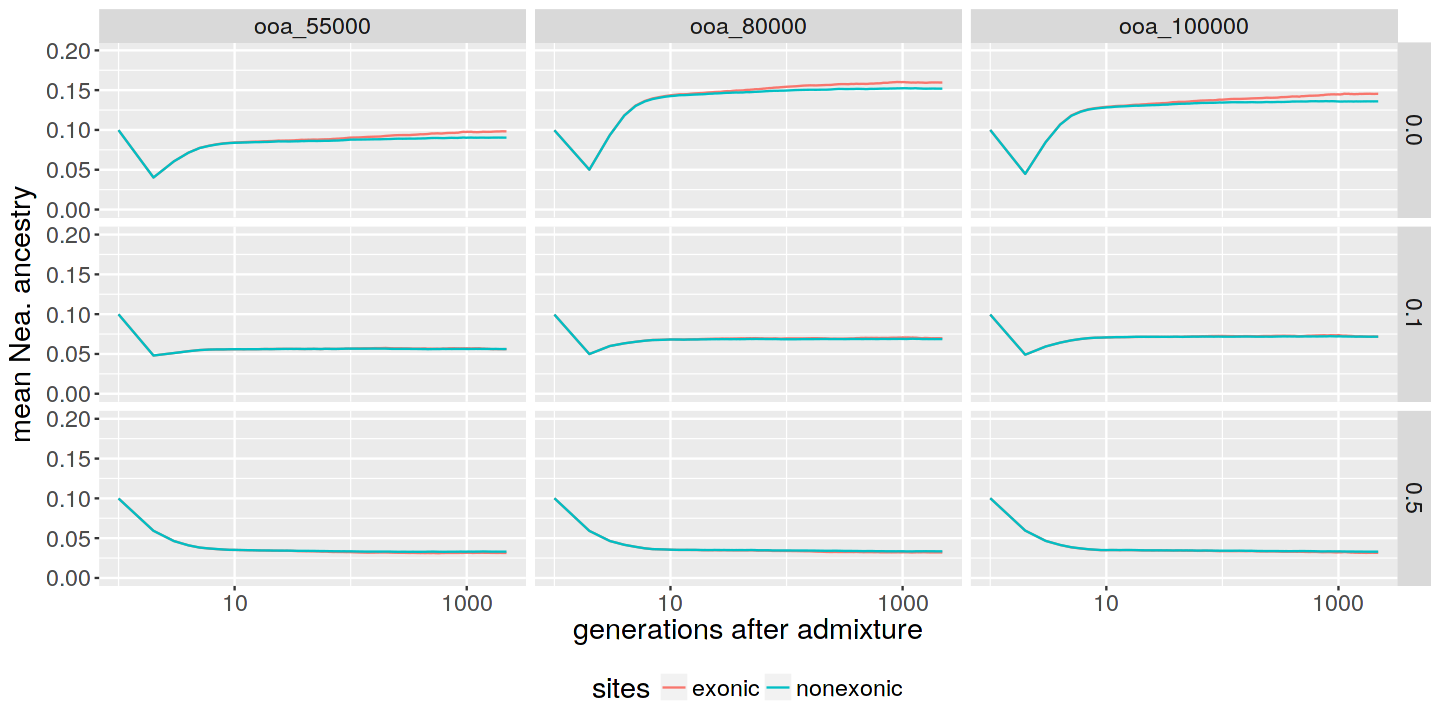

In [38]:
options(repr.plot.width=12, repr.plot.height=6)

plot_statistic(trajectories, "mean") + ylim(0, 0.2)
plot_statistic(trajectories, "mean", log_scale=TRUE) + ylim(0, 0.2)

# Epistasis

In [637]:
load_trajectories <- function(sim_dir, epistasis, n_pairs, s, init_nea, sites_subset) {
    if (!sites_subset %in% c("exonic", "nonexonic"))
        stop("Illegal subset of sites specified (must be \"exonic\" or \"nonexonic\").")

    # compose the pattern describing all input tables
    pattern <- paste0(paste0("sites_", epistasis, 
                             "__pairs_", n_pairs,
                             "__s_", s,
                             "__rep_.*",
                             "__", sites_subset, "_sites.txt"))

    # get paths of all input tables
    files <- list.files(sim_dir, pattern, full.names=TRUE)

    # load each table individually
    tables <- lapply(seq_along(files),
           function(i) {
                   read.table(files[i], header=TRUE) %>%
                       mutate(rep=i,
                              epistasis=epistasis,
                              n_pairs=n_pairs,
                              s=s,
                              sites=sites_subset)
           })

    # merge all dataframes into one and return the result
    do.call(rbind, tables)
}

In [638]:
pl <- function (trajectories, statistic, log_scale = FALSE) 
{
    summarized <- group_by(trajectories, gen, sites, epistasis, n_pairs, s) %>% 
        summarize_(statistic = interp(~mean(var), var = as.name(statistic)))
    p <- ggplot(summarized, aes(gen, statistic)) + geom_line(aes(color=n_pairs, group=n_pairs)) + 
        facet_grid(s ~ sites) + labs(y = paste(statistic, "Nea. ancestry"), 
        x = "generations after admixture") + theme(legend.position = "right", 
        text = element_text(size = 17)) +
        ylim(0, 0.1)
    if (log_scale) {
        p <- p + scale_x_log10()
    }
    p
}

In [639]:
pl_replicates <- function(trajectories, statistic, log_scale=FALSE) {
    p <- 
        trajectories %>%
        melt(id=c("gen", "rep", "n_pairs", "sites"), measure=c(statistic)) %>%
        ggplot(aes(gen, value)) +
            geom_line(aes(color=factor(rep))) +
            facet_grid(n_pairs ~ sites) +
            labs(title=paste(statistic,
                             "Nea. ancestry change on the",
                             ifelse(log_scale, "log time scale", "normal time scale")),
                 y=statistic,
                 x="generations")
    
    if (log_scale) {
        p <- p + scale_x_log10()
    }
    
    p
}

In [640]:
traject_dir <- "../simulations/epistasis_take2/"

In [641]:
epistasis <- c("exonic", "nonexonic")
sites <- c("exonic", "nonexonic")
n_pairs <- as.character(c(1000, 2000, 3000, 4000, 5000))
s <- c("0.001")

In [642]:
trajectories <-
    expand.grid(epistasis=epistasis, n_pairs=n_pairs, s=s, site=sites) %>%
    apply(1, function(comb) {
        load_trajectories(traject_dir, comb["epistasis"], comb["n_pairs"],
                          comb["s"], init_nea="0.1", comb["site"])
    }) %>%
    bind_rows %>%
    as_tibble

Warning message:
“Removed 2 rows containing missing values (geom_path).”

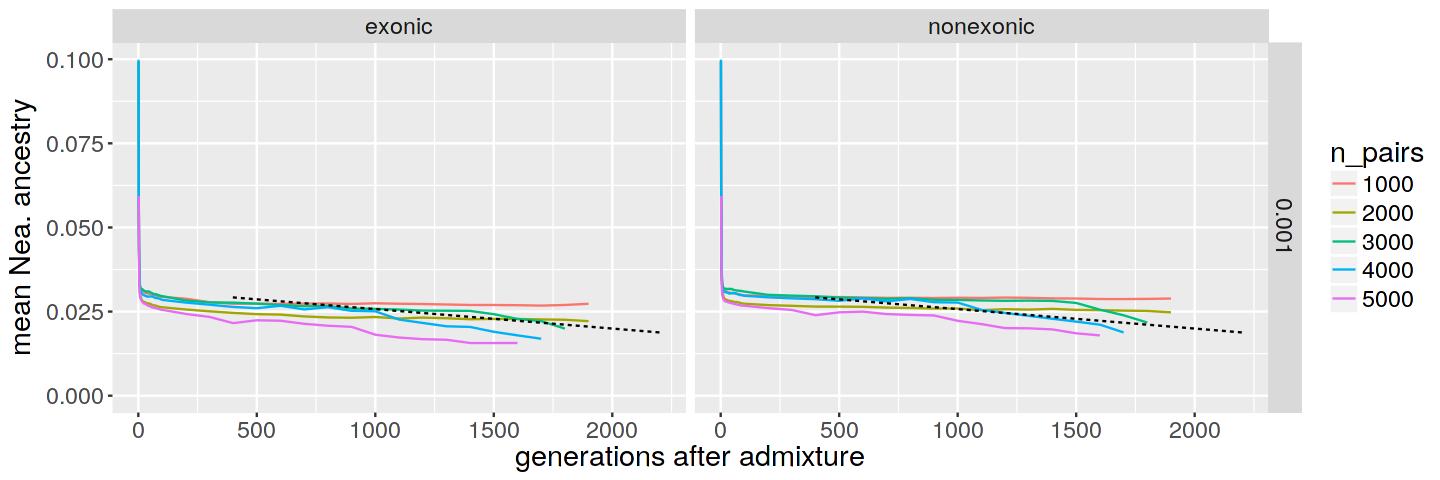

In [643]:
options(repr.plot.width=12, repr.plot.height=4)

pl(filter(trajectories, epistasis == "exonic"), "mean") + real_lm()

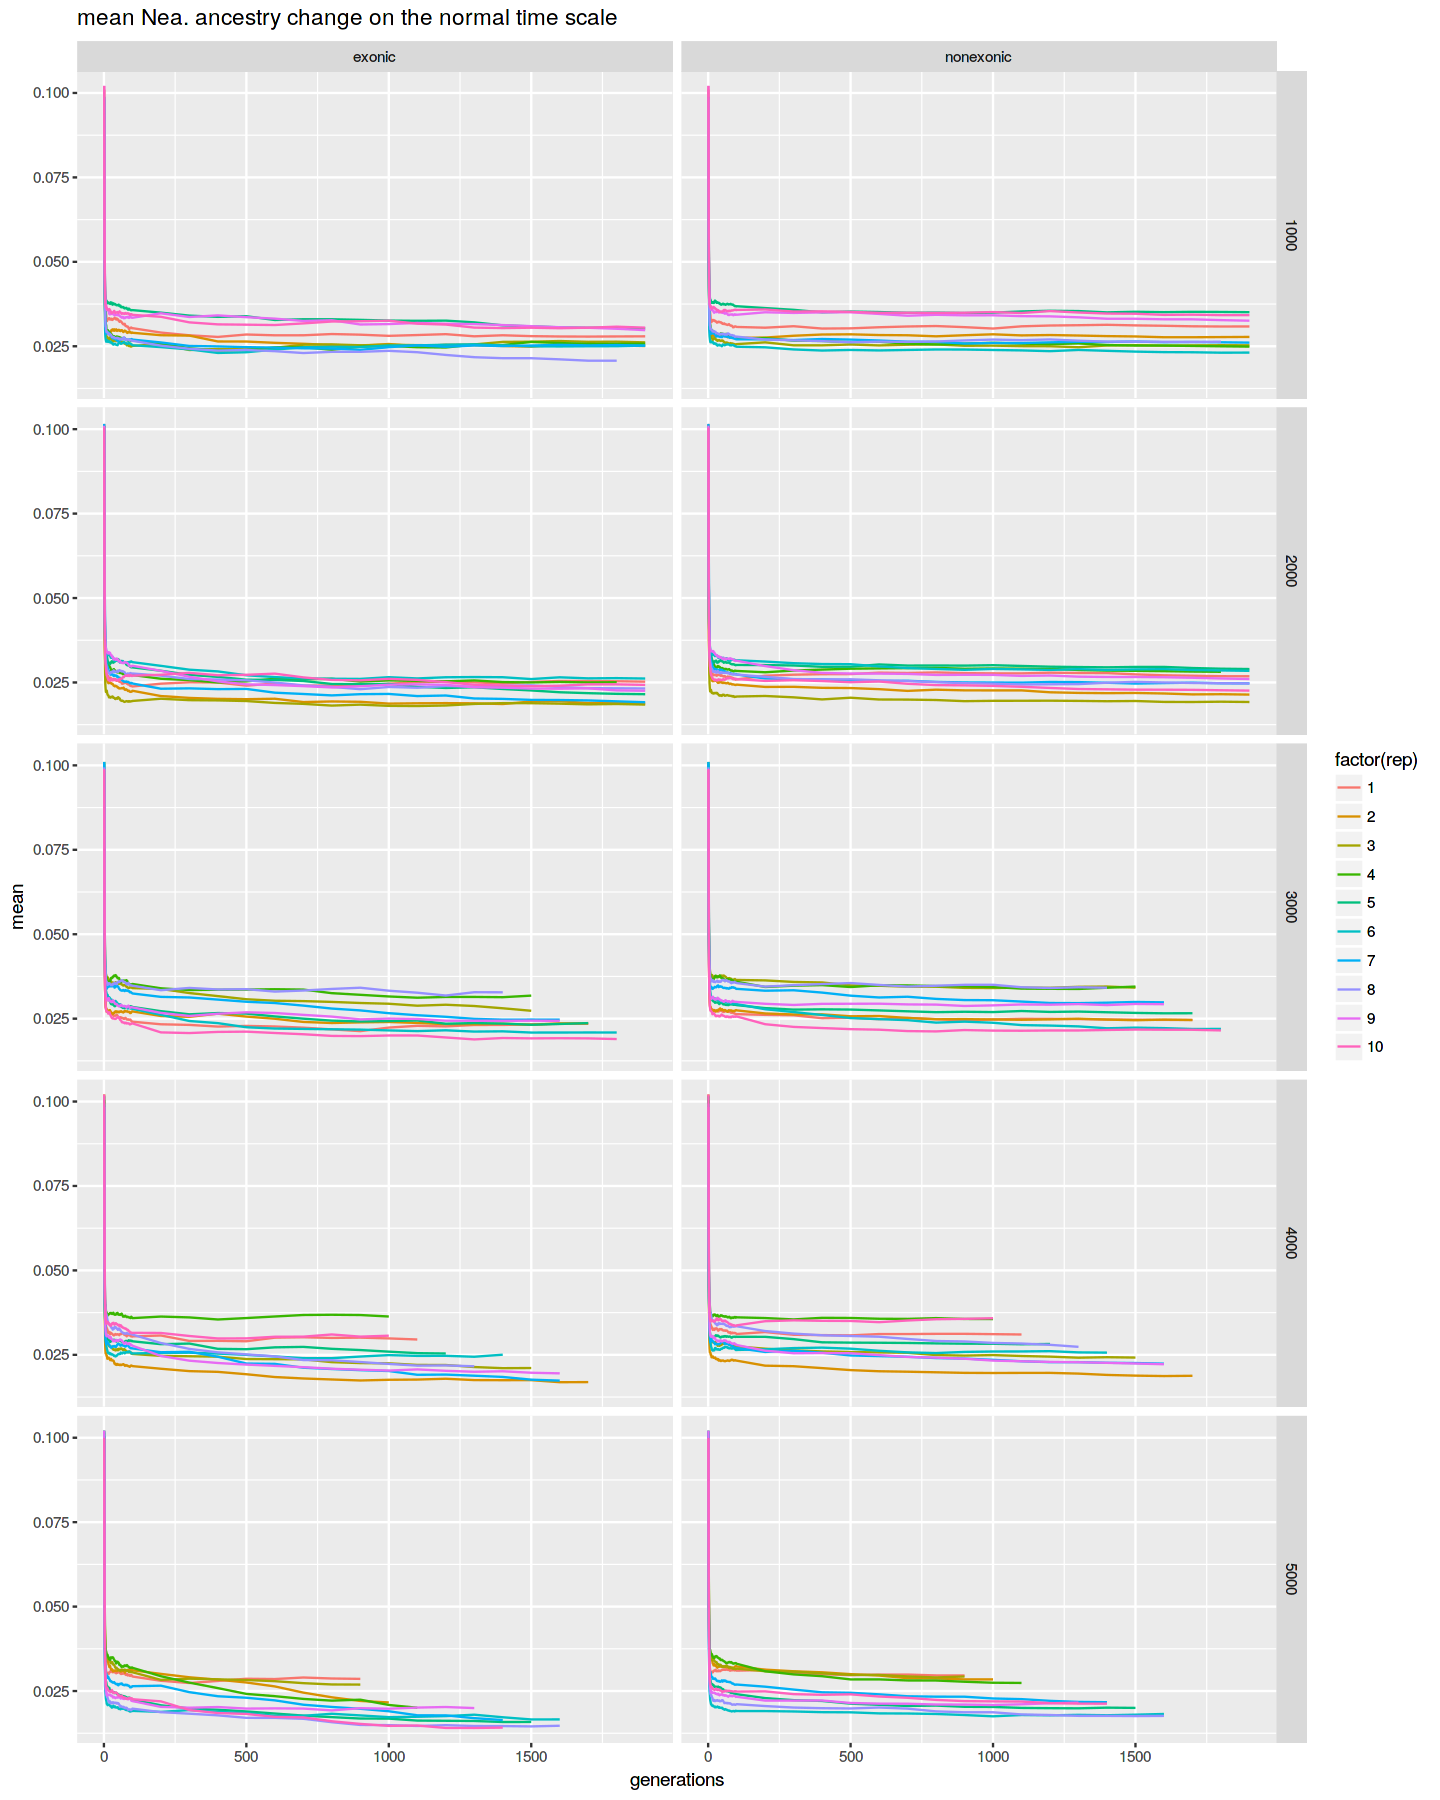

In [644]:
options(repr.plot.width=12, repr.plot.height=15)

pl_replicates(filter(trajectories, epistasis == "exonic"), "mean")

Warning message:
“Removed 1 rows containing missing values (geom_path).”

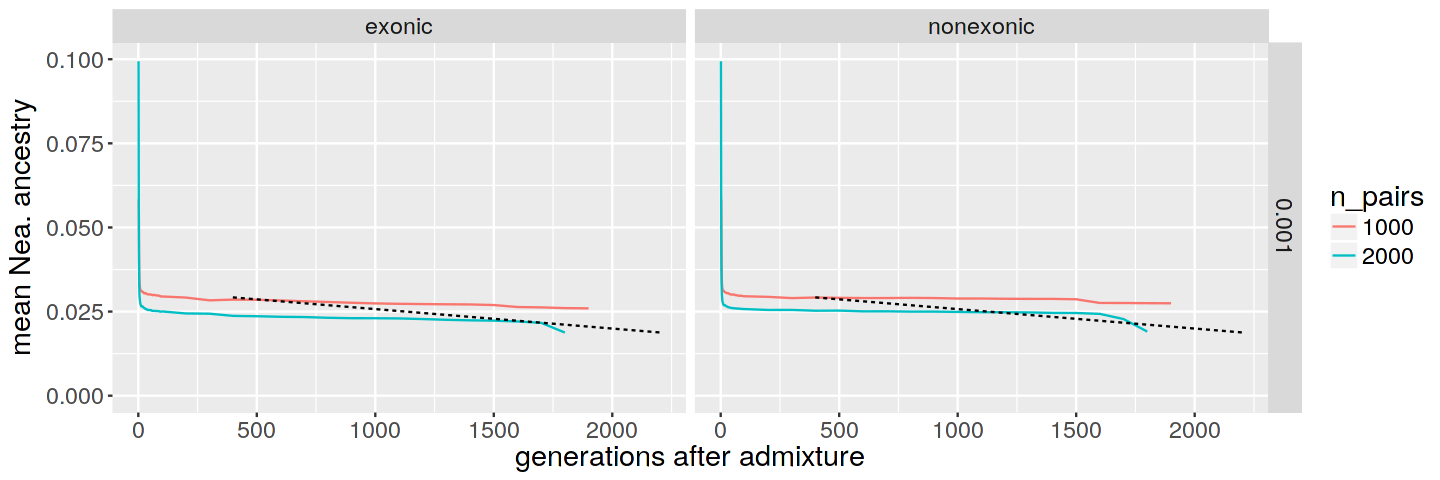

In [645]:
options(repr.plot.width=12, repr.plot.height=4)

pl(filter(trajectories, epistasis == "nonexonic"), "mean") + real_lm()

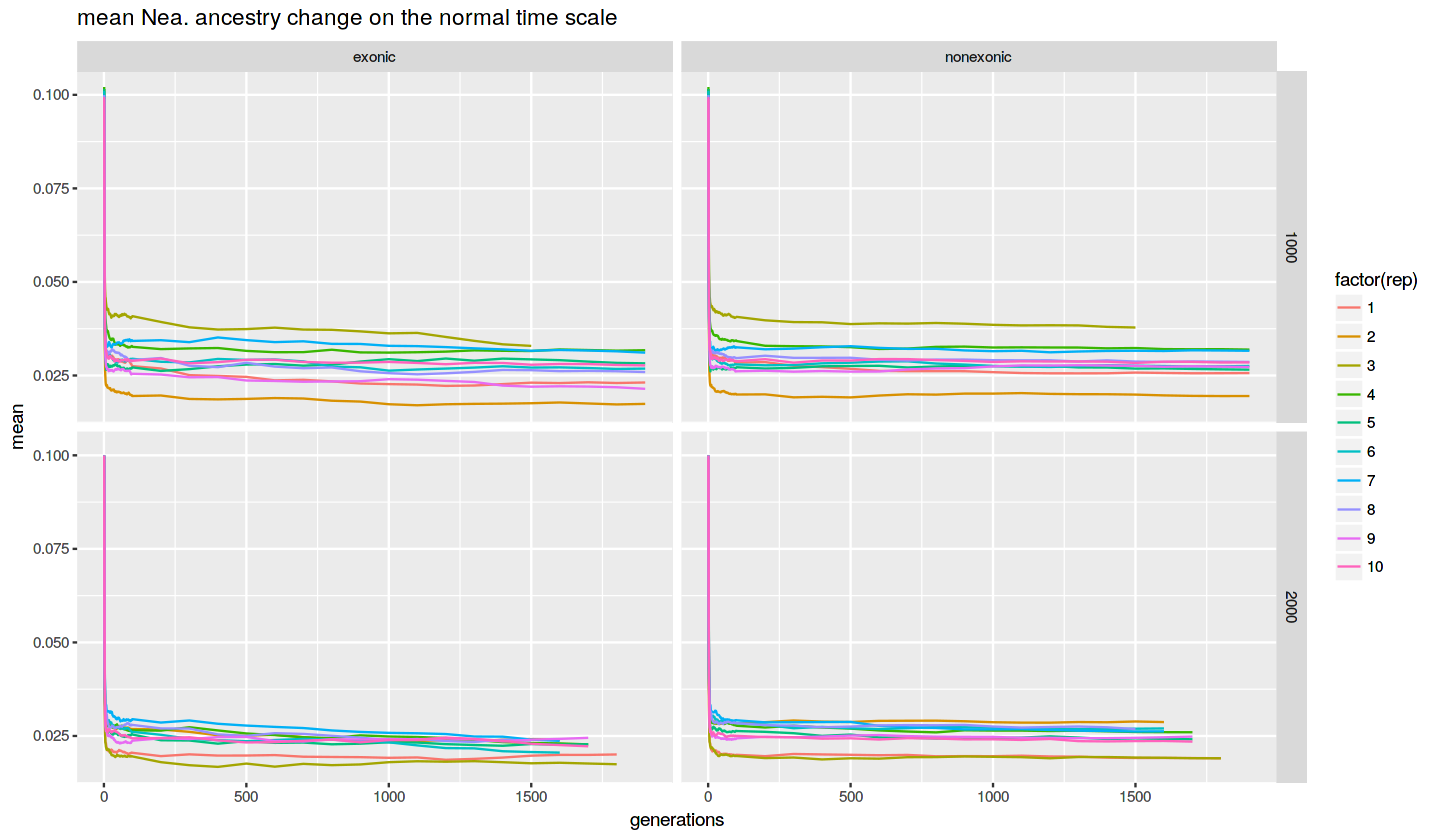

In [646]:
options(repr.plot.width=12, repr.plot.height=7)

pl_replicates(filter(trajectories, epistasis == "nonexonic"), "mean")

<br><br><br><br><br>
# Mixture of dominances

Idea: h = 0.0 and h = 0.5 have completely different outcomes - one scenario leads to an increased Nea% over time, another leads to a decrease over time. What happens if we simulate mixtures of both classes of mutations at the same time at different proportions?

## Simulating 10Mb region like a dummy

In [12]:
load_dominance_mix_trajectories <- function(sim_dir) {
    files <- list.files(sim_dir, full.names=TRUE, pattern="^h_mix_")
    tables <-
        lapply(seq_along(files),
               function(i) {
                   # extract parameters of a simulation from the simulation output filename
                   params <-
                       str_match(basename(files[i]), "^h_mix_(.*)_(.*)_(.*)__Ne_(.*)__r_(.*)__rep_(.*).txt") %>%
                       .[, 2 : ncol(.)] %>%
                       as.numeric
                   names(params) <- c("prop_add", "prop_partrec", "prop_rec", "Ne", "recomb_rate", "rep")
                   
                   # read the table with the simulation results and add parameters as additional columns
                   read.table(files[i], header=TRUE) %>%
                       mutate(rep=params["rep"],
                              prop_add=params["prop_add"],
                              prop_partrec=params["prop_partrec"],
                              prop_rec=params["prop_rec"],
                              recomb_rate=params["recomb_rate"])
               })
    bind_rows(tables) %>% as_tibble
}

In [13]:
trajectories <- load_dominance_mix_trajectories("../simulations/dominance_mix")

In [14]:
summarized_traj <-
    trajectories %>% group_by(gen, Ne, recomb_rate, prop_add, prop_partrec, prop_rec) %>% 
    summarize(stat=mean(mean)) %>% 
    mutate(props=paste(prop_add, prop_partrec, prop_rec))

In [15]:
options(repr.plot.width=12, repr.plot.height=5)

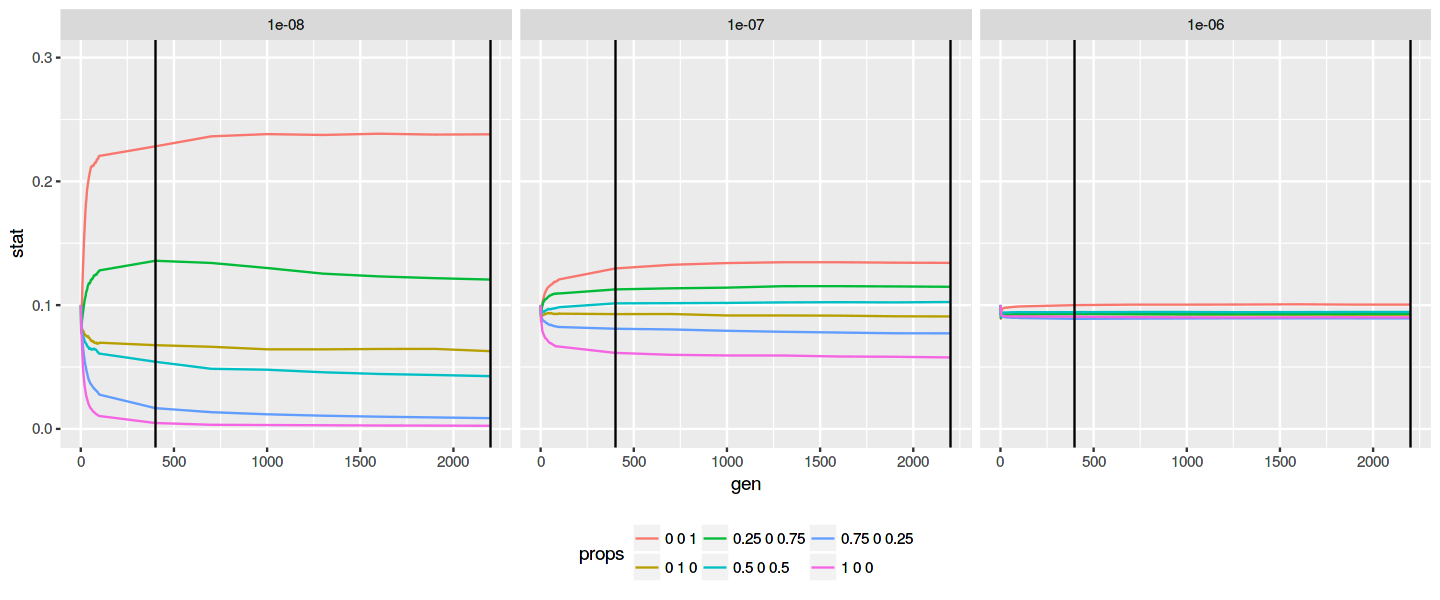

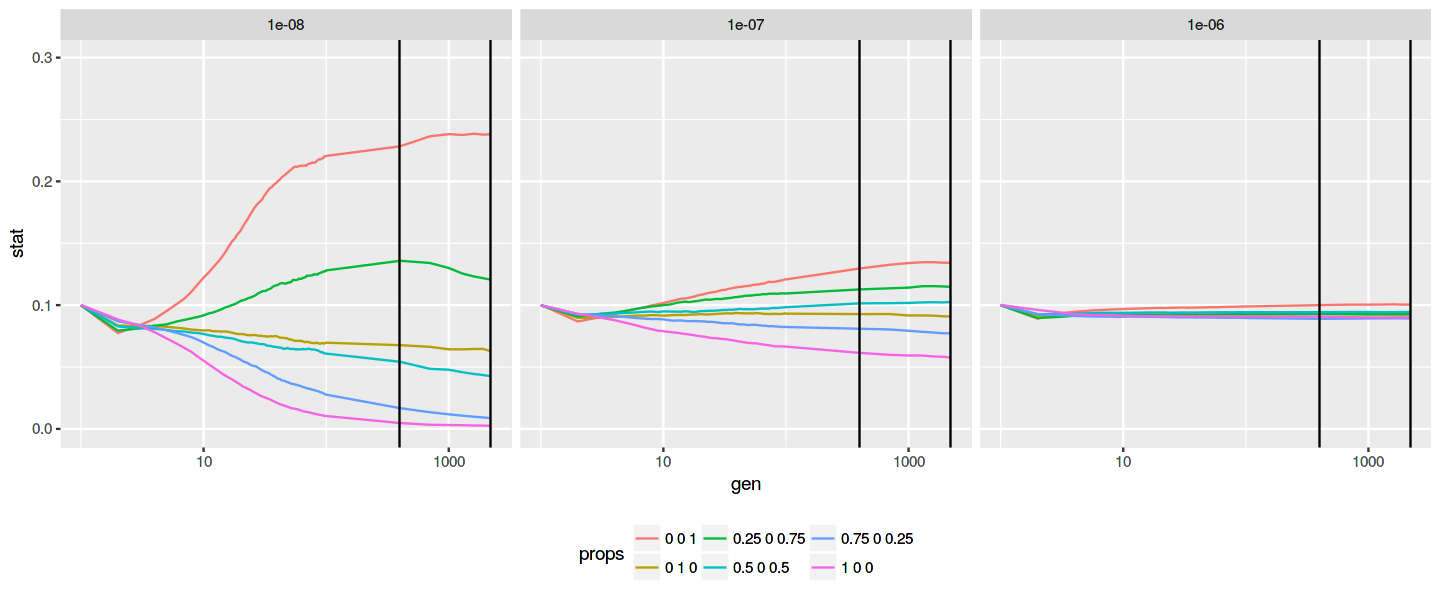

In [16]:
p <- ggplot(summarized_traj, aes(gen, stat, color=props)) +
    geom_line() +
    geom_vline(xintercept=c(400, 2200)) +
    facet_grid(. ~ recomb_rate) +
    coord_cartesian(ylim=c(0, 0.3)) +
    theme(legend.position="bottom")

p
p + scale_x_log10()

## Simulating whole exome + intergenic sites

In [17]:
load_dominance_mix_trajectories <- function(sim_dir) {
    files <- list.files("../simulations/dominance_mix/",
                        pattern="exons_and_sites__.*__exonic_sites.txt", full.names=TRUE)
    tables <-
        lapply(seq_along(files),
               function(i) {
                   # extract parameters of a simulation from the simulation output filename
                   params <-
                       str_match(basename(files[i]), "^exons_and_sites__(.*)_(.*)__rep_(.*)__.*.txt") %>%
                       .[, 2 : ncol(.)] %>%
                       as.numeric
                   names(params) <- c("prop_add", "prop_rec", "rep")
                   
                   # read the table with the simulation results and add parameters as additional columns
                   read.table(files[i], header=TRUE) %>%
                       mutate(rep=params["rep"],
                              prop_add=params["prop_add"],
                              prop_rec=params["prop_rec"])
               })
    bind_rows(tables) %>% as_tibble
}

In [18]:
trajectories <- load_dominance_mix_trajectories("../simulations/dominance_mix")

In [19]:
summarized_traj <-
    trajectories %>% group_by(gen, prop_add, prop_rec) %>% 
    summarize(stat=mean(mean)) %>% 
    mutate(props=paste(prop_add, prop_rec))

In [20]:
options(repr.plot.width=9, repr.plot.height=4)

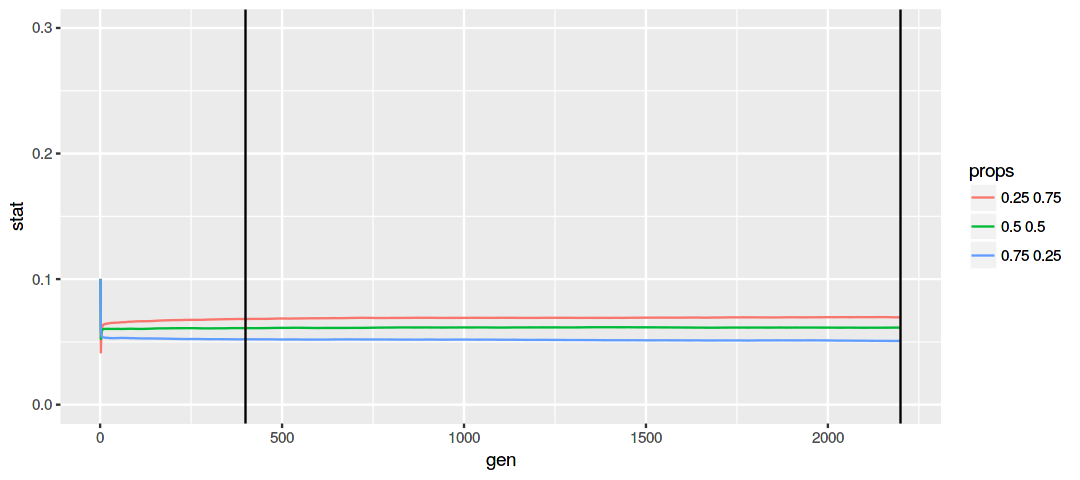

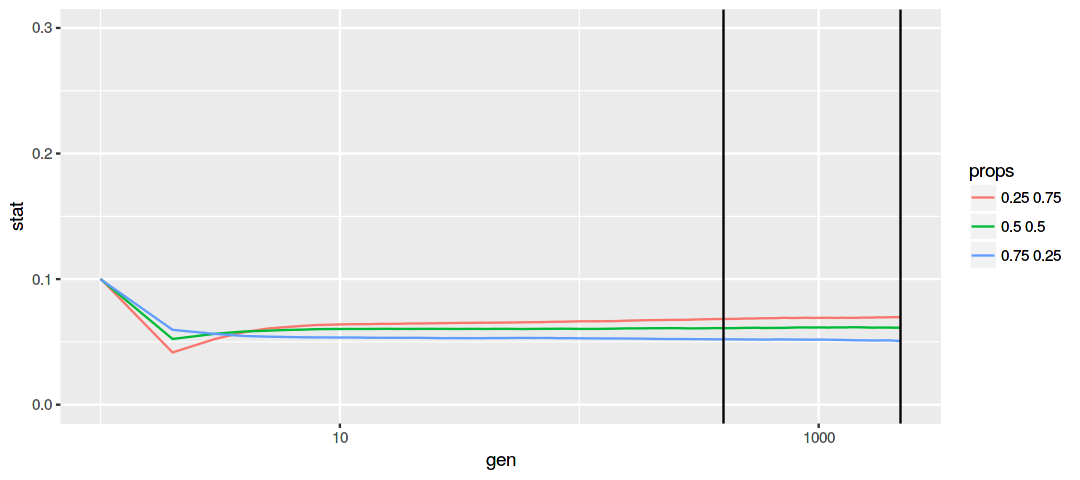

In [21]:
p <- ggplot(summarized_traj, aes(gen, stat, color=props)) +
    geom_line() +
    geom_vline(xintercept=c(400, 2200)) +
    coord_cartesian(ylim=c(0, 0.3))

p
p + scale_x_log10()

<br><br><br><br><br>
## A couple of dilution tests

This is just for testing the dilution code - the simulations are not supposed to make much sense!

In [22]:
options(repr.plot.width=12, repr.plot.height=5)

In [23]:
files <- list.files("../simulations/dilution/", "shortterm_dilution_.*__exonic.*", full.names = TRUE)
shortterm <-    
    seq_along(files) %>% 
    lapply(function(i) {
        read.table(files[i], header = TRUE) %>%
        mutate(rep = i, model = "short-term dilution", sites="exonic", h="0.5")
    }) %>% bind_rows()

files <- list.files("../simulations/dilution/", "longterm_dilution_.*__exonic.*", full.names = TRUE)
longterm <-    
    seq_along(files) %>% 
    lapply(function(i) {
        read.table(files[i], header = TRUE) %>%
        mutate(rep = i, model = "long-term dilution", sites="exonic", h="0.5")
    }) %>% bind_rows()

files <- list.files("../simulations/dilution/", "control.*__exonic.*", full.names = TRUE)
control <-    
    seq_along(files) %>% 
    lapply(function(i) {
        read.table(files[i], header = TRUE) %>%
        mutate(rep = i, model = "control", sites="exonic", h="0.5")
    }) %>% bind_rows()

In [24]:
do.call(rbind, list(shortterm, longterm, control)) -> x

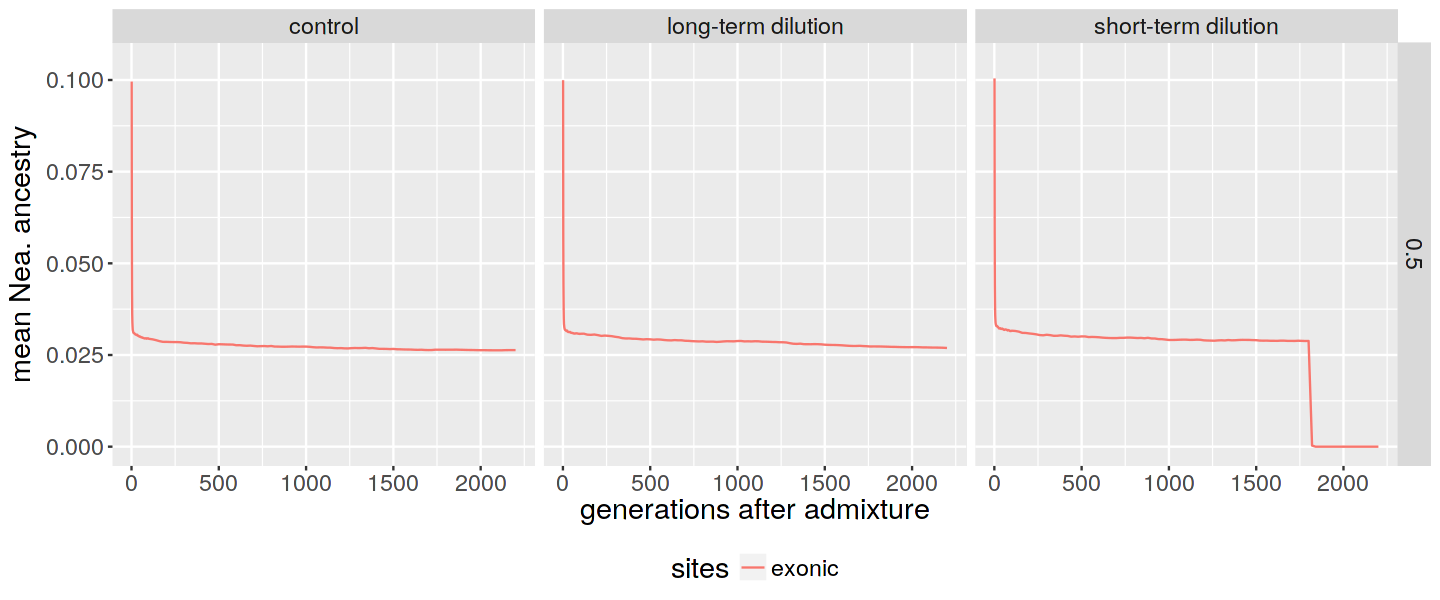

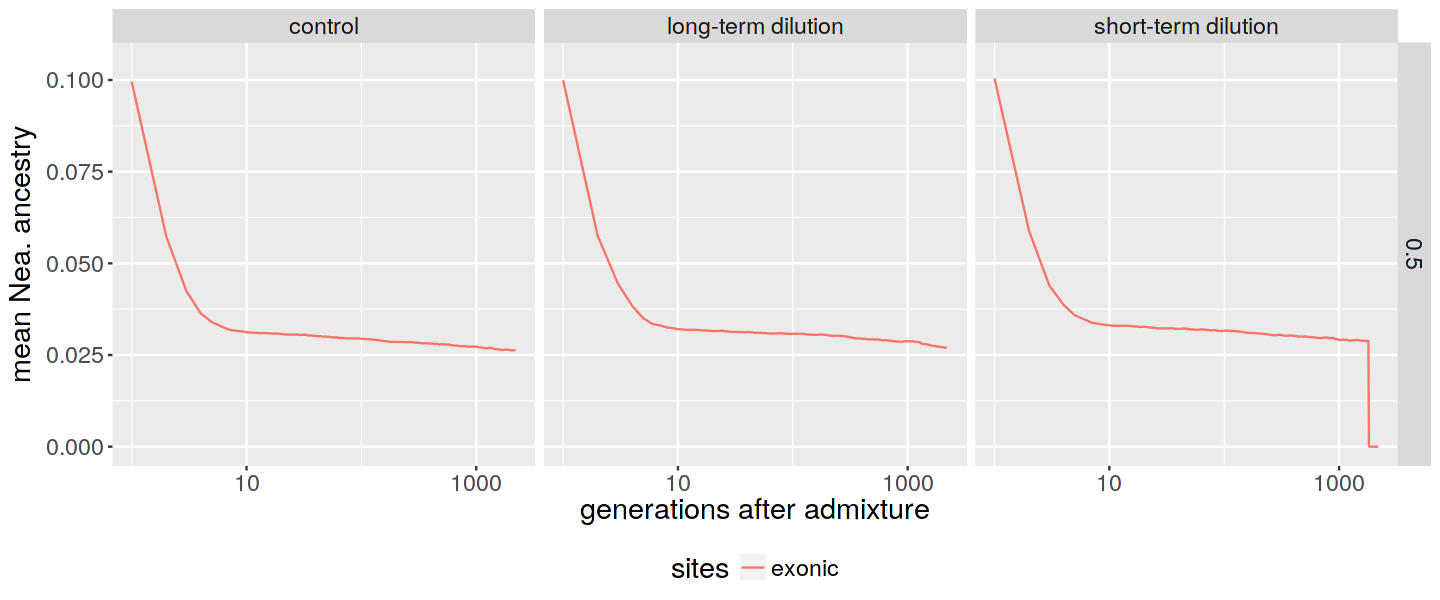

In [25]:
plot_statistic(x, "mean")
plot_statistic(x, "mean", log_scale=TRUE)

Warning message:
“Removed 2 rows containing missing values (geom_path).”

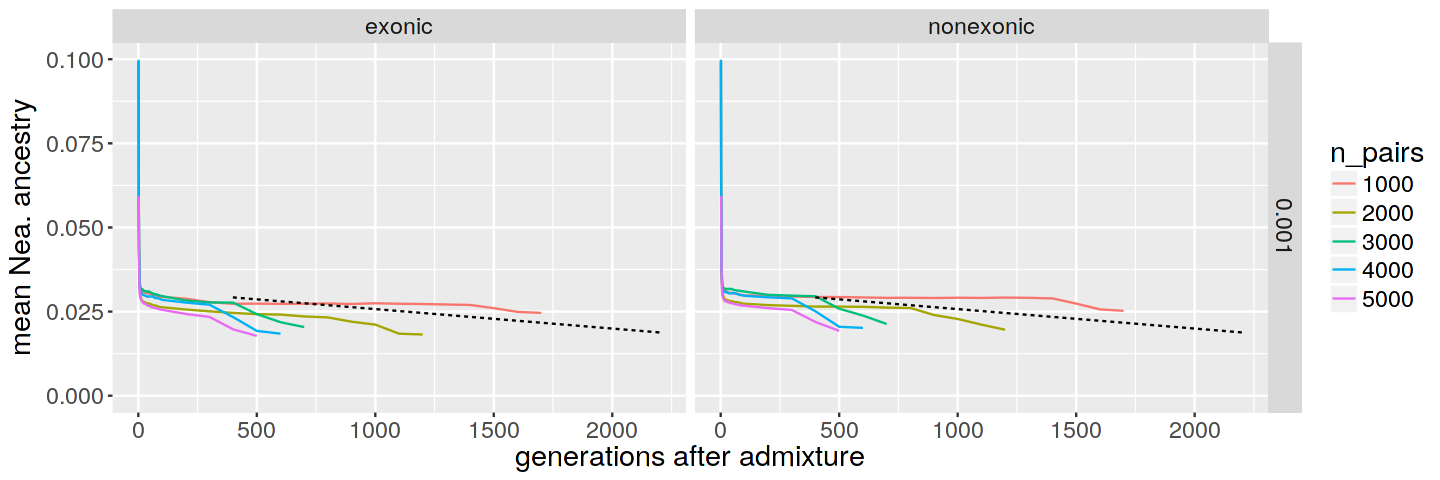

In [145]:
options(repr.plot.width=12, repr.plot.height=4)

pl(filter(trajectories, epistasis == "exonic"), "mean") + real_lm()